In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import sys
sys.path.insert(0,'../data_utils/')
from Sample import Sample
from NewSample import coords_to_dists
from OrigamiTransform import OrigamiTransform
from tensor_support import remove_diagonal as remove_diagonal_fcn
origami_transform = OrigamiTransform()

plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style.txt')

In [2]:
use_corrected_structures = True#True #False

In [3]:
segment_length = 64
remove_diagonal = True

#chrom = '1'
# Must only hold 1 chrom to avoid loading all embeddings
chroms = ['1']#str(k) for k in range(1,23)]

config_fp = '../../data/processed_data.hdf5'
embedding_dir = '../../data/embeddings_64_after_transformer/'
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

#unguided_fp = '../../data/samples/origami_64_no_embed_reduction/pt_files/sample_unguided_milestone_120_combined.pt'
unguided_fp = '../../data/samples/origami_64_no_embed_reduction/eval_mode/unguided.pt'
#unguided_fp = '../../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt'

save_folder = './distance_statistics/'
#unguided_fp = '../../data/samples/origami_64_no_embed_reduction/sample_144_3.0_1.0_36_1.pt'

In [4]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
file_mod = '_corrected' if use_corrected_structures else ''

In [5]:
def remove_diagonal1(mat):

    n = mat.shape[-1]
    mat2 = torch.empty(
        *mat.shape[:-2],n-1,n-1,
        dtype=mat.dtype,
        device=mat.device
    )
    i,j = torch.triu_indices(n,n,1)
    mat2[...,i,j-1] = mat[...,i,j]
    mat2[...,j-1,i] = mat[...,j,i]

    return mat2

def add_diagonal1(mat,diag_value=0):

    n = mat.shape[-1]
    mat2 = torch.empty(
        *mat.shape[:-2],n+1,n+1,
        dtype=mat.dtype,
        device=mat.device
    )
    i,j = torch.triu_indices(n,n,0)
    mat2[...,i,j+1] = mat[...,i,j]
    mat2[...,j+1,i] = mat[...,j,i]
    i = torch.arange(n+1)
    mat2[...,i,i] = diag_value

    return mat2


def load_data(filepath):

    data = torch.load(filepath)
    data = origami_transform.inverse(data) 
    data = remove_diagonal1(data) 

    sample = Sample(data=data)
    sample.unnormalize_()

    data = sample.unflatten()
    data = add_diagonal1(data,0)

    return data

def load_sample_pt(filepath):

    data = torch.load(filepath)
    data = origami_transform.inverse(data) 
    data = remove_diagonal1(data) 

    sample = Sample(data=data)
    sample.unnormalize_()

    return sample 
    

In [6]:
import mdtraj as md
def coords_from_dcd(dcd_fp,psf_fp):
    t = md.load(dcd_fp,top=psf_fp)
    coords = torch.from_numpy(10*t.xyz).unsqueeze(1) # to maintain consistency with other code
    return coords
    
def dists_from_dcd(dcd_fp,psf_fp):
    coords = coords_from_dcd(dcd_fp,psf_fp)
    return coords_to_dists(coords)

In [7]:
#gen_dcd = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_64_no_embed_reduction/dcd_files/sample_unguided_milestone_120_combined.dcd'
#gen_psf = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_64_no_embed_reduction/dcd_files/sample_unguided_milestone_120_combined.psf'
if use_corrected_structures:
    #gen_dists = dists_from_dcd(gen_dcd,gen_psf)
    gen_dists = coords_to_dists(torch.load('../../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt')).unsqueeze(1)
else:
    gen_dists = load_data(unguided_fp)
    # Remove frames with infinite values
    finite_frames = torch.where(gen_dists.isfinite().all(-1).all(-1))
    
    gen_dists = gen_dists[finite_frames[0],finite_frames[1],:,:].unsqueeze(1)
    del finite_frames


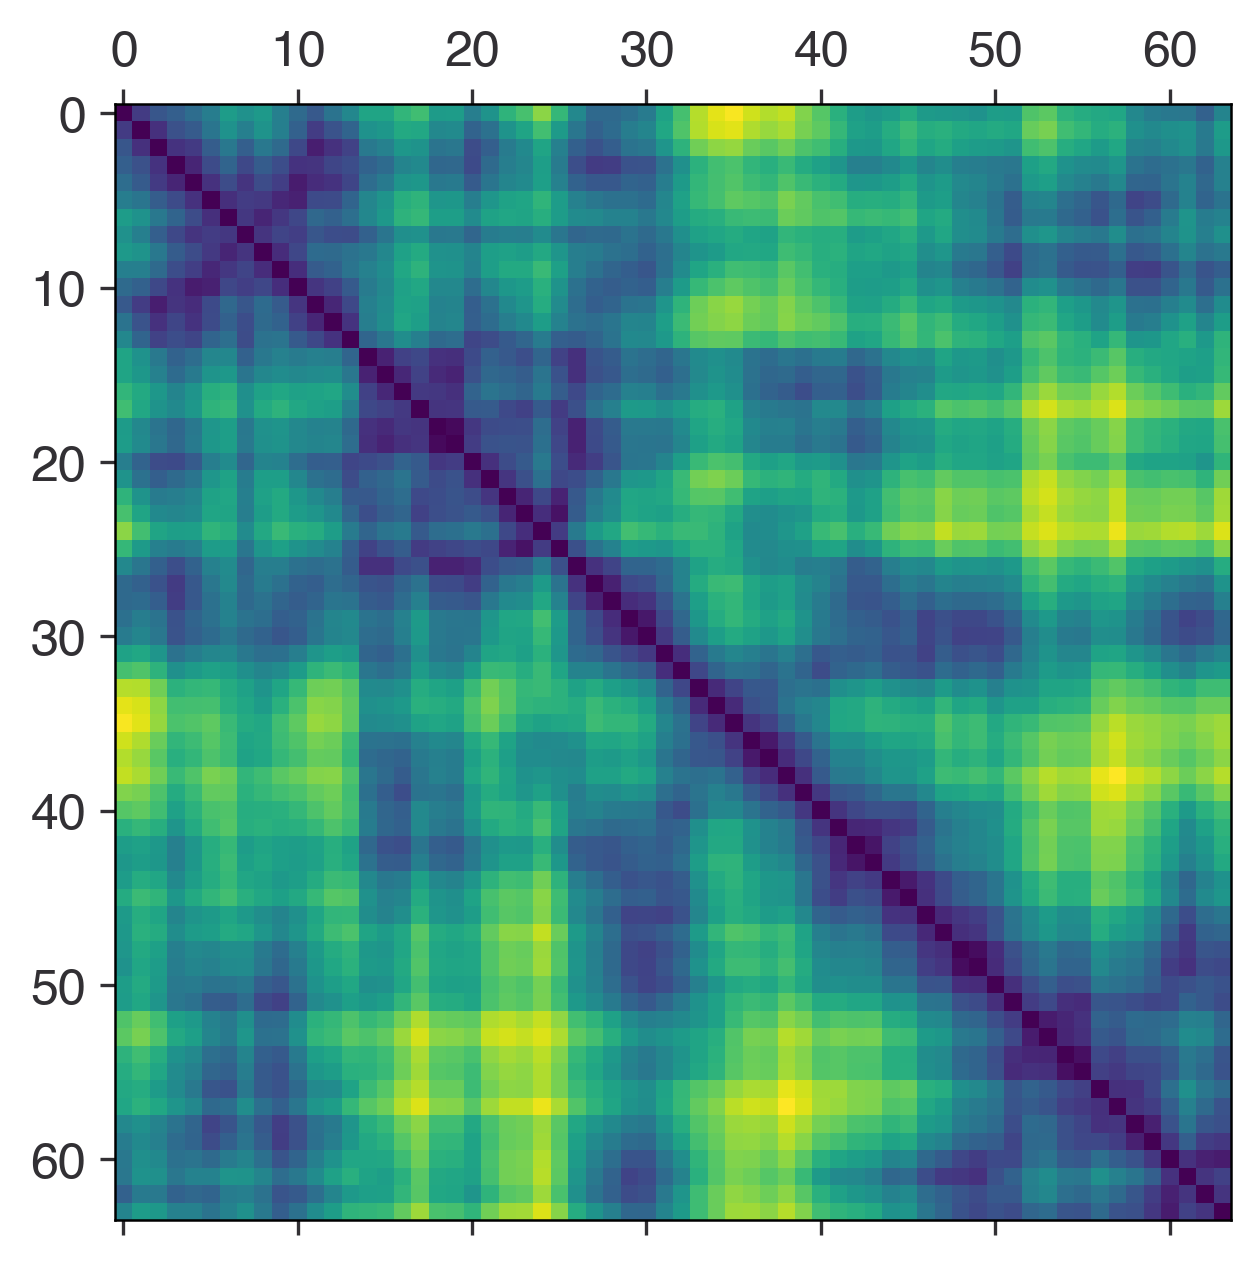

In [8]:
plt.matshow(gen_dists[0,0,...].cpu().numpy())

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'I', 'L', 'M', 'P', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'w', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 39, 44, 47, 48, 51, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90, 91, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 43 glyphs after
INFO:fo

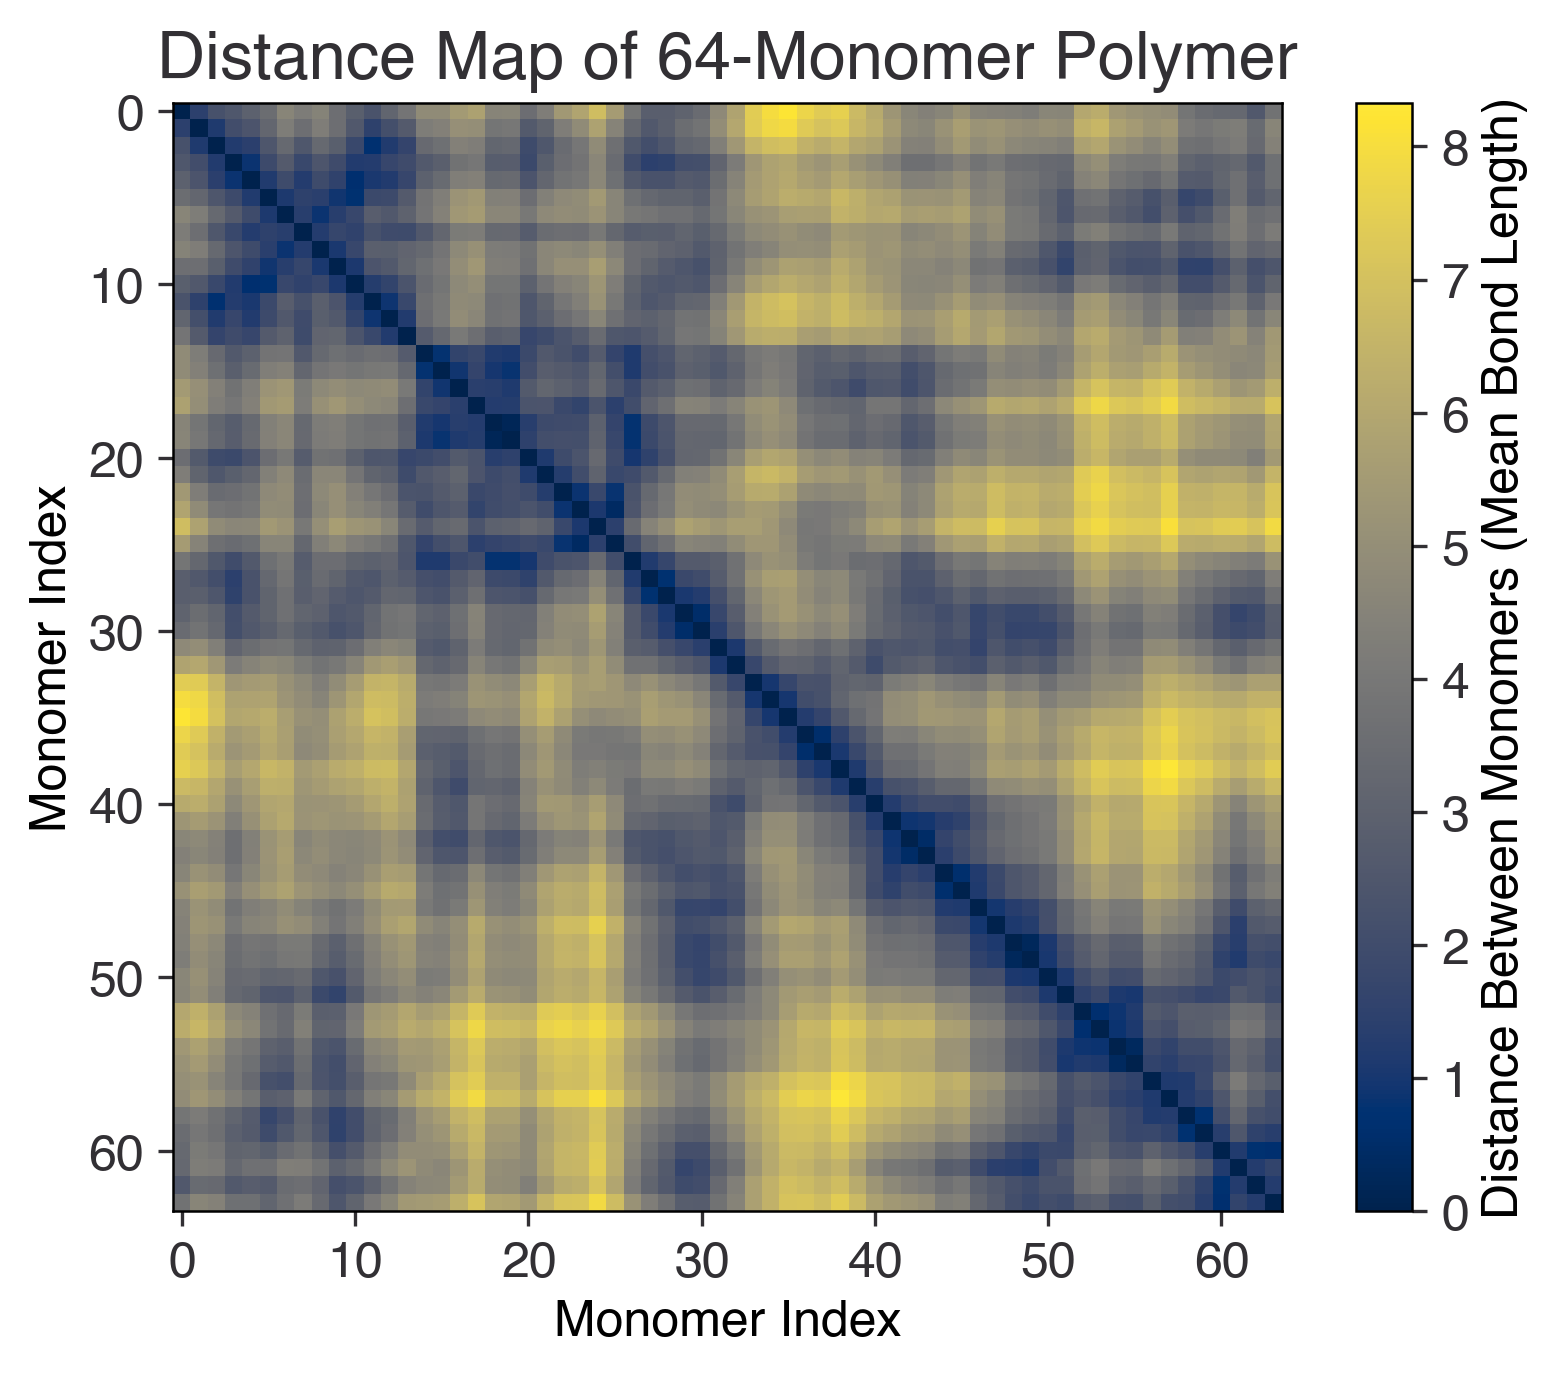

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(gen_dists[0,0,...].cpu().numpy(),cmap='cividis')
cbar = fig.colorbar(im) 
cbar.set_label('Distance Between Monomers (Mean Bond Length)')
ax.set_xlabel('Monomer Index')
ax.set_ylabel('Monomer Index')
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax.set_title('Distance Map of 64-Monomer Polymer')

fig.savefig(save_folder+f'dist_map{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'G', 'H', 'I', 'L', 'M', 'R', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'v', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 42, 43, 44, 47, 48, 53, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 45 glyphs a

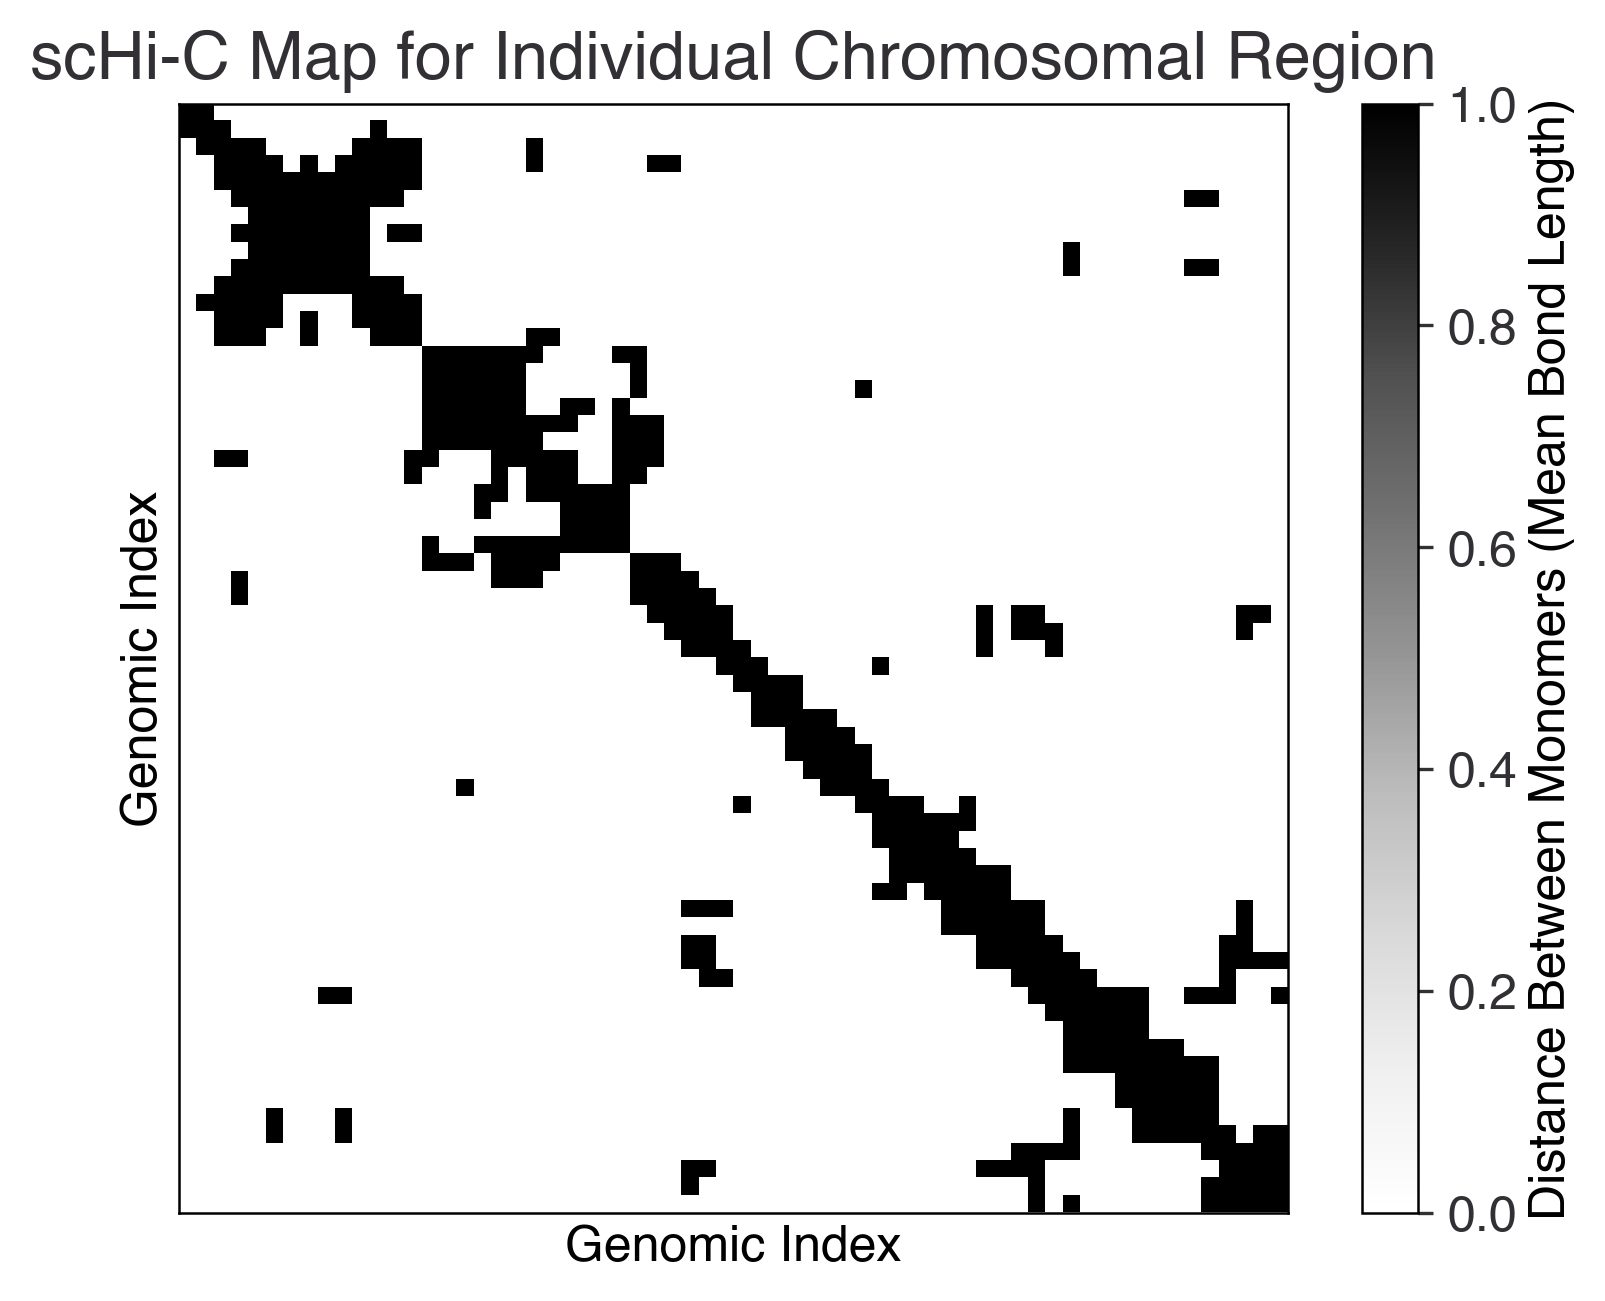

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

rc = 2

deprecated_map = gen_dists[0,0,...].clone()
n = deprecated_map.shape[-1]
i,j = torch.triu_indices(n,n,0)
m = deprecated_map[i,j]
m[m>rc] = torch.nan 
m[m.isfinite()] = 1
deprecated_map[i,j] = m 
deprecated_map[j,i] = m 

im = ax.matshow(deprecated_map.cpu().numpy(),cmap='Greys',vmin=0,vmax=1)
cbar = fig.colorbar(im) 
cbar.set_label('Distance Between Monomers (Mean Bond Length)')
ax.set_xlabel('Genomic Index')
ax.set_ylabel('Genomic Index')
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('scHi-C Map for Individual Chromosomal Region')

fig.savefig(save_folder+f'full_schic_map{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'G', 'H', 'I', 'L', 'M', 'R', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'v', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 42, 43, 44, 47, 48, 53, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 45 glyphs a

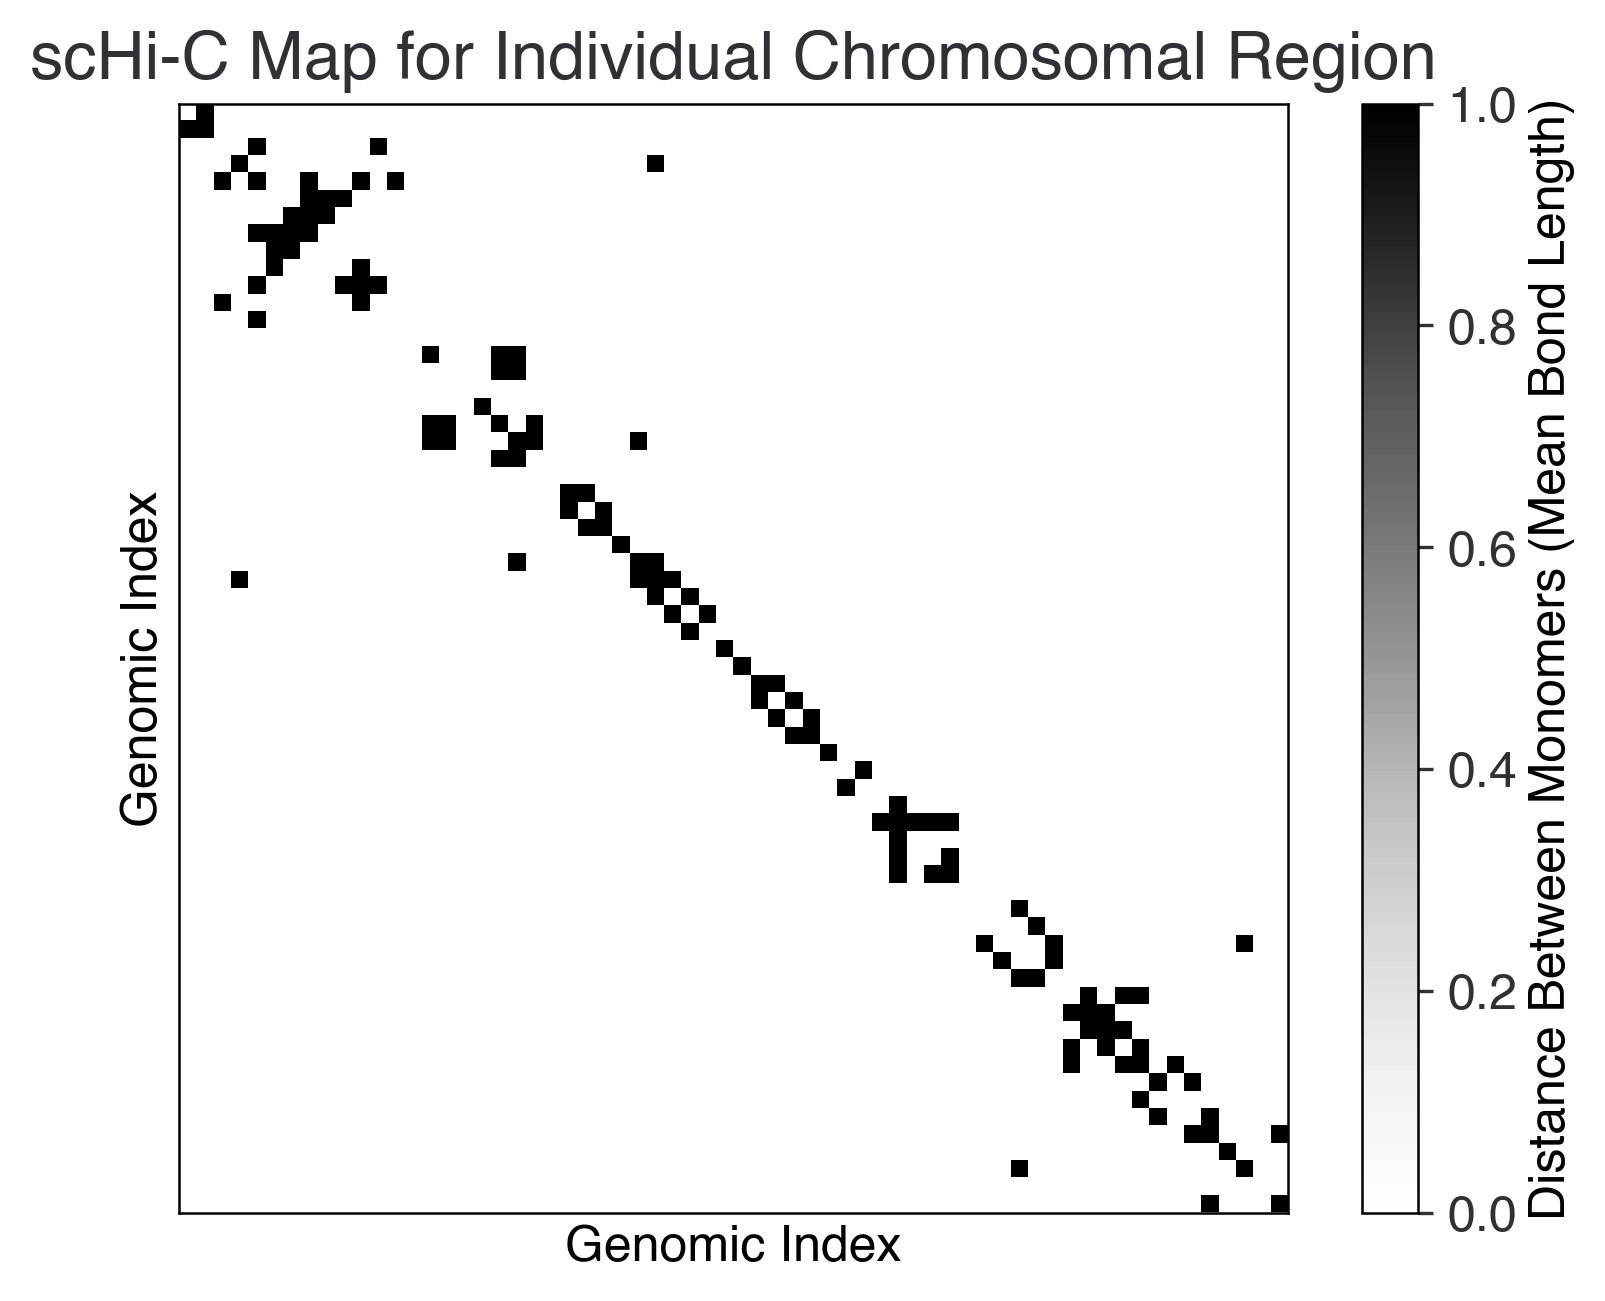

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

rc = 1.5

deprecated_map = gen_dists[0,0,...].clone()
n = deprecated_map.shape[-1]
i,j = torch.triu_indices(n,n,0)
m = deprecated_map[i,j]
m[m>rc] = torch.nan 
nn = len(m) 
m[torch.rand(nn) < .5] = torch.nan
m[m.isfinite()] = 1
m[~m.isfinite()] = 0 
deprecated_map[i,j] = m 
deprecated_map[j,i] = m 

im = ax.matshow(deprecated_map.cpu().numpy(),cmap='Greys')
cbar = fig.colorbar(im) 
cbar.set_label('Distance Between Monomers (Mean Bond Length)')
ax.set_xlabel('Genomic Index')
ax.set_ylabel('Genomic Index')
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('scHi-C Map for Individual Chromosomal Region')

fig.savefig(save_folder+f'deprecated_hic_map_{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'G', 'H', 'I', 'L', 'M', 'R', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 38, 39, 42, 43, 44, 47, 48, 53, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91]
INFO:fontTools.subset:Closed glyph list 

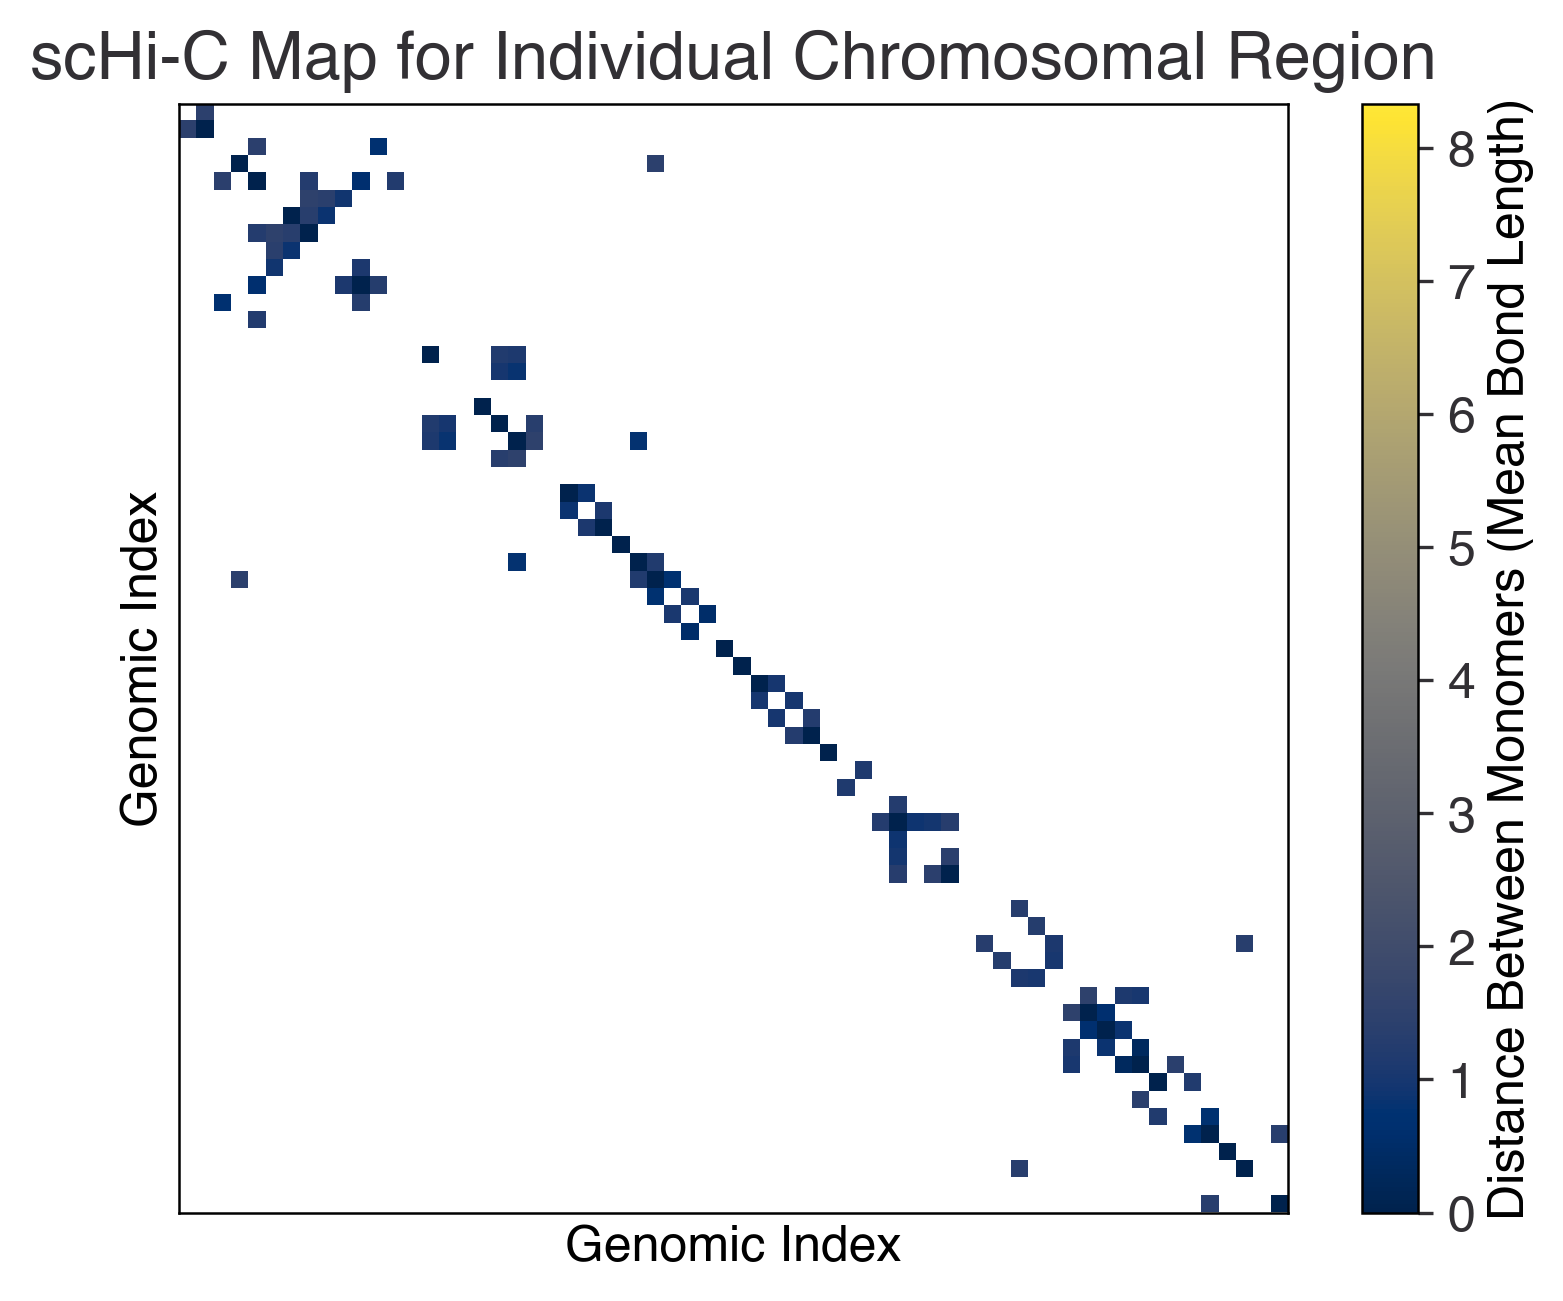

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

rc = 1.5

deprecated_map = gen_dists[0,0,...].clone()
n = deprecated_map.shape[-1]
i,j = torch.triu_indices(n,n,0)
mm = deprecated_map[i,j]
mm[m==0] = torch.nan
deprecated_map[i,j] = mm
deprecated_map[j,i] = mm

im = ax.matshow(deprecated_map.cpu().numpy(),cmap='cividis',vmin=0,vmax=gen_dists[0,0,...].max().cpu().numpy())
cbar = fig.colorbar(im) 
cbar.set_label('Distance Between Monomers (Mean Bond Length)')
ax.set_xlabel('Genomic Index')
ax.set_ylabel('Genomic Index')
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('scHi-C Map for Individual Chromosomal Region')

fig.savefig(save_folder+f'deprecated_hic_map_dists{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'I', 'L', 'M', 'P', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'w', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 37, 39, 44, 47, 48, 51, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90, 91, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 43 glyphs after
INFO:fo

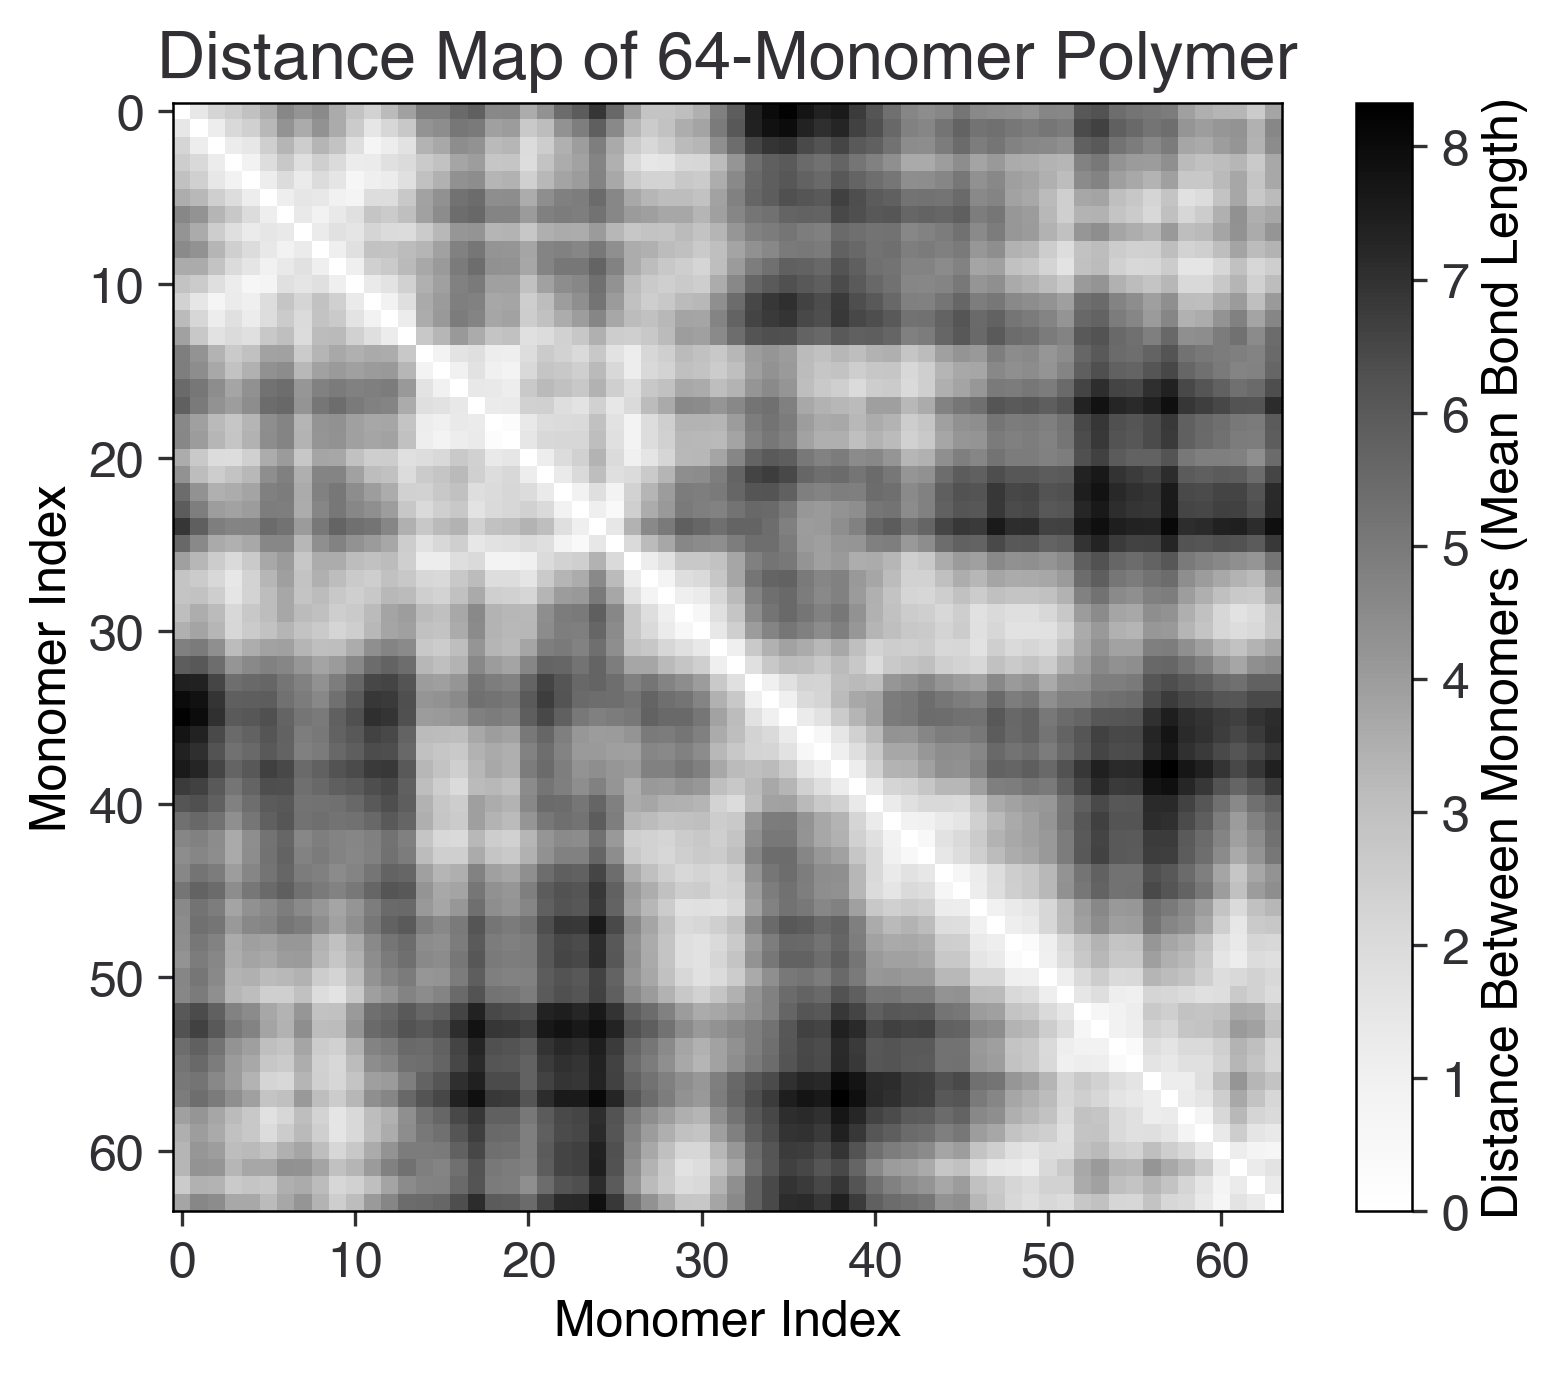

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(gen_dists[0,0,...].cpu().numpy(),cmap='Greys')
cbar = fig.colorbar(im) 
cbar.set_label('Distance Between Monomers (Mean Bond Length)')
ax.set_xlabel('Monomer Index')
ax.set_ylabel('Monomer Index')
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax.set_title('Distance Map of 64-Monomer Polymer')

fig.savefig(save_folder+f'dist_map2{file_mod}.pdf')

#### Relying on the sample class more heavily, as in the benchmarking folder's DistanceDistribution location 

In [14]:
def is_square(mat):
    s = mat.shape
    assert len(s) > 1, f'Tensor must have at least two dimensions. Provided shape: {s}'
    return s[-1] == s[-2]

def copy_matrix_elements(from_mat,to_mat):
    assert is_square(from_mat) and is_square(to_mat), f'Both matrices must be square in the final two dimensions'

    n1,n2= from_mat.shape[-1],to_mat.shape[-1]
    n,N = min(n1,n2),max(n1,n2)

    i,j = torch.triu_indices(n,n,0)

    shift1,shift2 = max(0,n1-n2),max(0,n2-n1)
    to_mat[...,i,shift2+j] = from_mat[...,i,shift1+j]
    to_mat[...,shift2+j,i] = from_mat[...,shift1+j,i]
    

def add_diagonal(mat,diag_value=0):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'
    
    N = mat.shape[-1] + 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    i = torch.arange(N)
    new_mat[...,i,i] = diag_value

    return new_mat

def remove_diagonal(mat):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'

    N = mat.shape[-1] - 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    
    return new_mat

In [15]:
import torch

def distance_hist(exp_data,gen_data,**kwargs):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(gen_data.flatten().cpu().numpy(),alpha=0.5,label='Generated',density=True,**kwargs)
    #ax.hist(exp_data.flatten().cpu().numpy(),alpha=0.5,label='Experimental',density=True,**kwargs)
    ax.hist(exp_data.flatten().cpu().numpy(),alpha=0.5,label='Longzhi Tan Dataset',density=True,**kwargs)
    ax.legend()

    return fig,ax

def is_int(x):
    return int(x) == x

class DistanceCompare: 

    def __init__(self,config_dataset,sample=None,indices=None,device=None):

        self.exp_ds = config_dataset
        self.gen_configs = sample
        self.idx = indices
        self.device = device

        self.exp_maps = None

    ###################################################################
    # Handling the experimental data
    def parse_index(self,region_index): 
        assert is_int(region_index), 'region_index must be an integer'
        _,chrom,start_idx = self.idx[region_index]
        return chrom,start_idx

    def get_coords(self,*args):
        assert len(args) > 0, 'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received no arguments.'
        assert len(args) < 3, f'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received {len(args)} arguments.'
        if len(args) == 1: 
            assert type(args[0]) == int, f'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received one {type(args[0])} input.'
            chrom,start_idx = self.parse_index(int(args[0]))
        elif type(args[0]) != str or not is_int(args[1]): 
            raise Exception('Expected either integer input (region index) or string (chrom) followed by integer (starting index). '+\
                            f'Received types {type(args[0])} and {type(args[1])}.')
        else:
            chrom,start_idx = args[0],int(args[1])
        return self.exp_ds.fetch_specific_coords(chrom,start_idx)[1].to(self.device)
        
    
    def get_exp_maps(self,*args):
        if len(args) == 0:
            return self.exp_maps
        coords = self.get_coords(*args) 
        dists = torch.cdist(coords.double(),coords.double()).float()
        return dists

    def set_exp_maps(self,*args):
        if len(args) == 1 and type(args[0]) == torch.Tensor and len(args[0].shape) == 3: 
            self.exp_maps = args[0].clone()
        else:
            self.exp_maps = self.get_exp_maps(*args)

    ###################################################################
    # Handling the generated data 
    def set_sample(self,sample):

        sample.unnormalize_()
        idx_to_keep = sample.unflatten().isfinite().all(-1).all(-1)
        sample.batch = sample.batch[idx_to_keep,...]
        self.gen_configs = sample
        
        '''
        self.gen_configs = sample#.clone()
        self.gen_configs.unnormalize_()
        '''
    def load_sample(self,fp):
        #sample = Sample(data=pd.read_pickle(fp).batch)
        if fp[-4:] == '.pkl':
            sample = pd.read_pickle(fp)
        else:
            sample = load_sample_pt(fp)
        self.set_sample(sample)
        
        
    ###################################################################
    # Comparisons
    def dist_compare(self,pairs=None,plot=False,**kwargs):
        gen_data = self.gen_configs.unflatten()
        exp_data = self.get_exp_maps()
        n, N = gen_data.shape[-1], exp_data.shape[-1]

        if n == N-1: 
            gen_data = add_diagonal(gen_data) 
        else: 
            assert n==N, 'incompatible generated/experimental data sizes'

        if pairs is None: 
            pairs = torch.triu_indices(N,N,1).T.tolist()

        results = {}
        for pair in pairs: 
            i,j = pair[0],pair[1]
            results[tuple(pair)] = [exp_data[...,i,j].flatten(),gen_data[...,i,j].flatten()]

        if plot: 
            exp_data = []
            gen_data = []
            for _,item in results.items():
                exp_data.append(item[0])
                gen_data.append(item[1])
            exp_data = torch.cat(exp_data)
            gen_data = torch.cat(gen_data) 
            fig,ax = distance_hist(exp_data,gen_data,**kwargs)
            return results,fig,ax
        else:
            return results 

    def compare_specific_separation(self,separation,**kwargs):
        N = self.get_exp_maps().shape[-1]
        i = torch.arange(separation,N)
        j = torch.arange(0,len(i))
        pairs = [(i[k],j[k]) for k in range(len(i))]
        #dists = self.dist_compare(pairs,plot=True)
        return self.dist_compare(pairs,plot=True,**kwargs)
        '''
        exp_data = []
        gen_data = []
        for _,item in dists.items():
            exp_data.append(item[0])
            gen_data.append(item[1])
        exp_data = torch.cat(exp_data)
        gen_data = torch.cat(gen_data) 
        fig,ax = distance_hist(exp_data,gen_data,**kwargs)
        return fig,ax
        '''

    def correlation_compare(self,contact=None):
        n = self.exp_maps.shape[-1]
        if contact is None:
            bead_i = n // 4
            bead_j = 3*bead_i
        else:
            bead_i,bead_j = contact

        i,j = torch.triu_indices(n,n,1)
        correlations = torch.empty_like(self.exp_maps[0,...])
        gen_dists = self.gen_configs.unflatten()
        for bead_i1 in range(n-1):
            for bead_j1 in range(bead_i1+1,n):
                correlations[bead_i1,bead_j1] = torch.corrcoef(
                    torch.stack(
                        [
                            self.exp_maps[...,bead_i,bead_j].double(),
                            self.exp_maps[...,bead_i1,bead_j1].double()
                        ],
                        dim = 0
                    )
                ).to(correlations.dtype)[0,1]

                correlations[bead_j1,bead_i1] = torch.corrcoef(
                    torch.stack(
                        [
                            gen_dists[...,bead_i,bead_j-1].double(), # diagonal is removed in the sample
                            gen_dists[...,bead_i1,bead_j1-1].double()
                        ],
                        dim = 0
                    )
                ).to(dtype=correlations.dtype,device=correlations.device)[0,1]

        i = torch.arange(correlations.shape[-1])
        correlations[i,i] = torch.nan
                
        return correlations
        


#### Longzhi Tan Data

In [16]:
import sys
sys.path.insert(1,'../data_utils/')
from ConfigDataset import ConfigDataset
from EmbeddedRegions import EmbeddedRegions

In [17]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=segment_length,
    remove_diagonal=True,
    batch_size=0,
    normalize_distances=False, #True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=chroms, #[str(chrom)],#training_chroms,
    replicates=[1],#None,
    shuffle=False,#True,
    allow_overlap=False,#True, # To avoid bias 
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)
print('Loading Embeddings',flush=True)
'''
er = EmbeddedRegions(
    embedding_dir,
    chroms=chroms, #[str(chrom)]#training_chroms
)
'''
er_index = pd.read_pickle(embedding_dir + '/rosetta_stone.pkl')[chroms[0]]

Loading Embeddings


In [18]:
#indices = pd.read_pickle()

dist_compare = DistanceCompare(config_ds,indices=er_index)#er.index)

# Set the Tan data
# Simple band-aid for now to compare the stats for multiple regions. 
if os.path.exists('./dist_maps_processed.pt'):
    dist_maps = torch.load('./dist_maps_processed.pt',map_location=config_ds.device)
else:
    
    coords = []
    for _,chrom,start_idx in er_index:#er.index:
        _,tcoords = config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)
        if tcoords is not None:
            coords.append(tcoords)
    coords = torch.cat(coords,dim=0)
    dist_maps = torch.cdist(coords,coords)
    torch.save(dist_maps.cpu(),'./dist_maps_processed.pt')
    del coords
dist_compare.set_exp_maps(dist_maps)

# Load the generated data 
if use_corrected_structures:
    dist_compare.set_sample(Sample(data=remove_diagonal_fcn(gen_dists)))
else:
    dist_compare.load_sample(unguided_fp)

comparisons = dist_compare.dist_compare()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'E', 'G', 'L', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'w', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 24, 26, 37, 39, 40, 42, 47, 48, 51, 54, 55, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 92, 93]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 44 glyphs after
INFO:fontTo

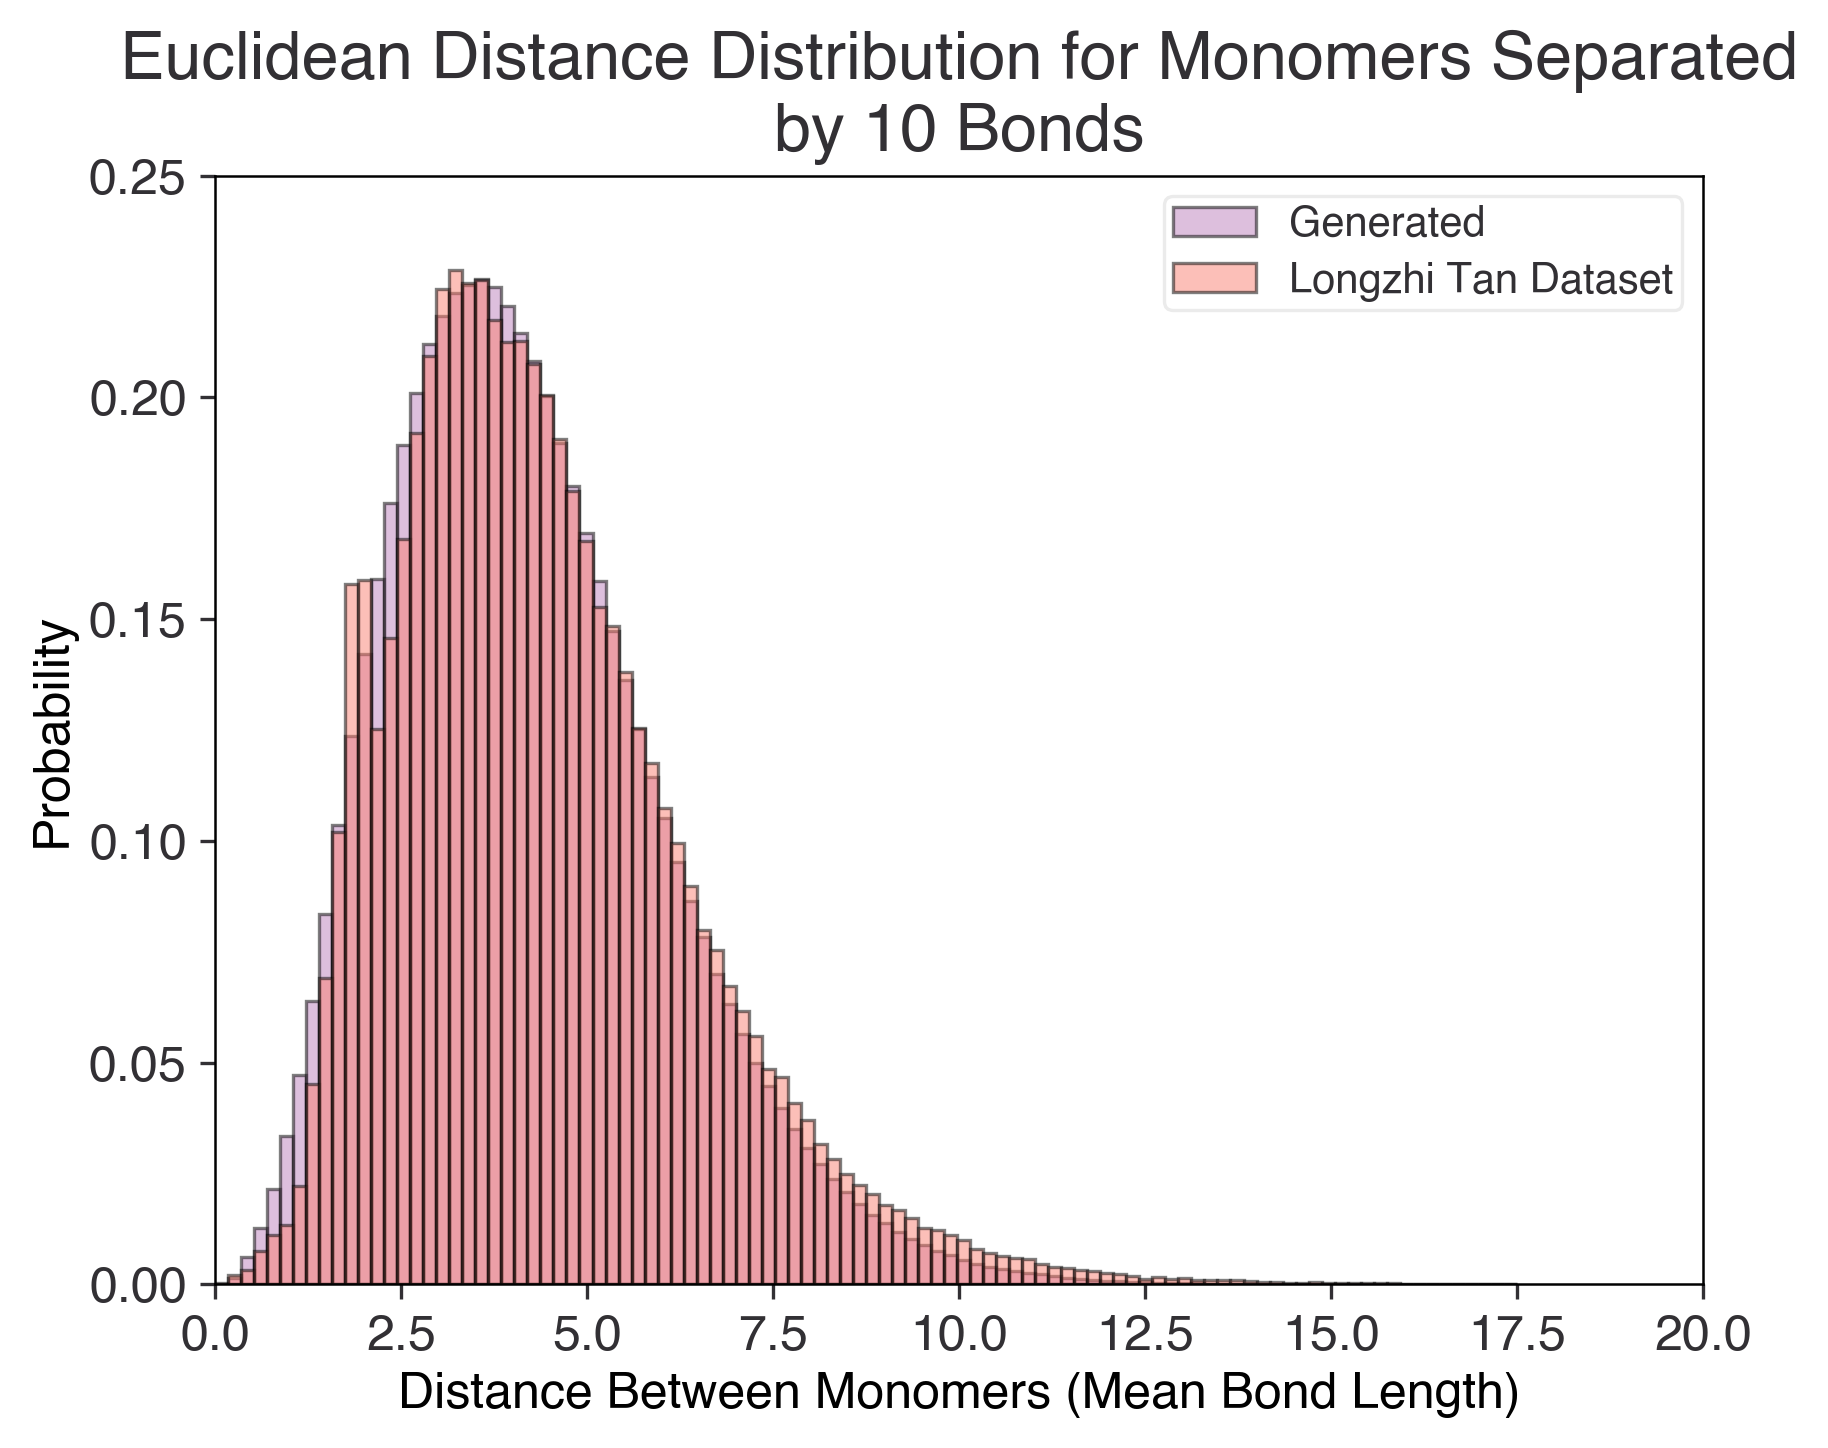

In [19]:
_,fig,ax = dist_compare.compare_specific_separation(10,bins=torch.arange(0,17.51,.175));#,bins=torch.arange(0,10,.05).numpy());
ax.set_xlabel('Distance Between Monomers (Mean Bond Length)')
ax.set_ylabel('Probability')
ax.set_title('Euclidean Distance Distribution for Monomers Separated\nby 10 Bonds')
ax.set_xlim([0,20])

fig.savefig(save_folder+f'dists_10{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'E', 'G', 'L', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 27, 37, 39, 40, 42, 47, 48, 51, 54, 55, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 92, 93]
INFO:fontTools.subset:Closed glyph list over

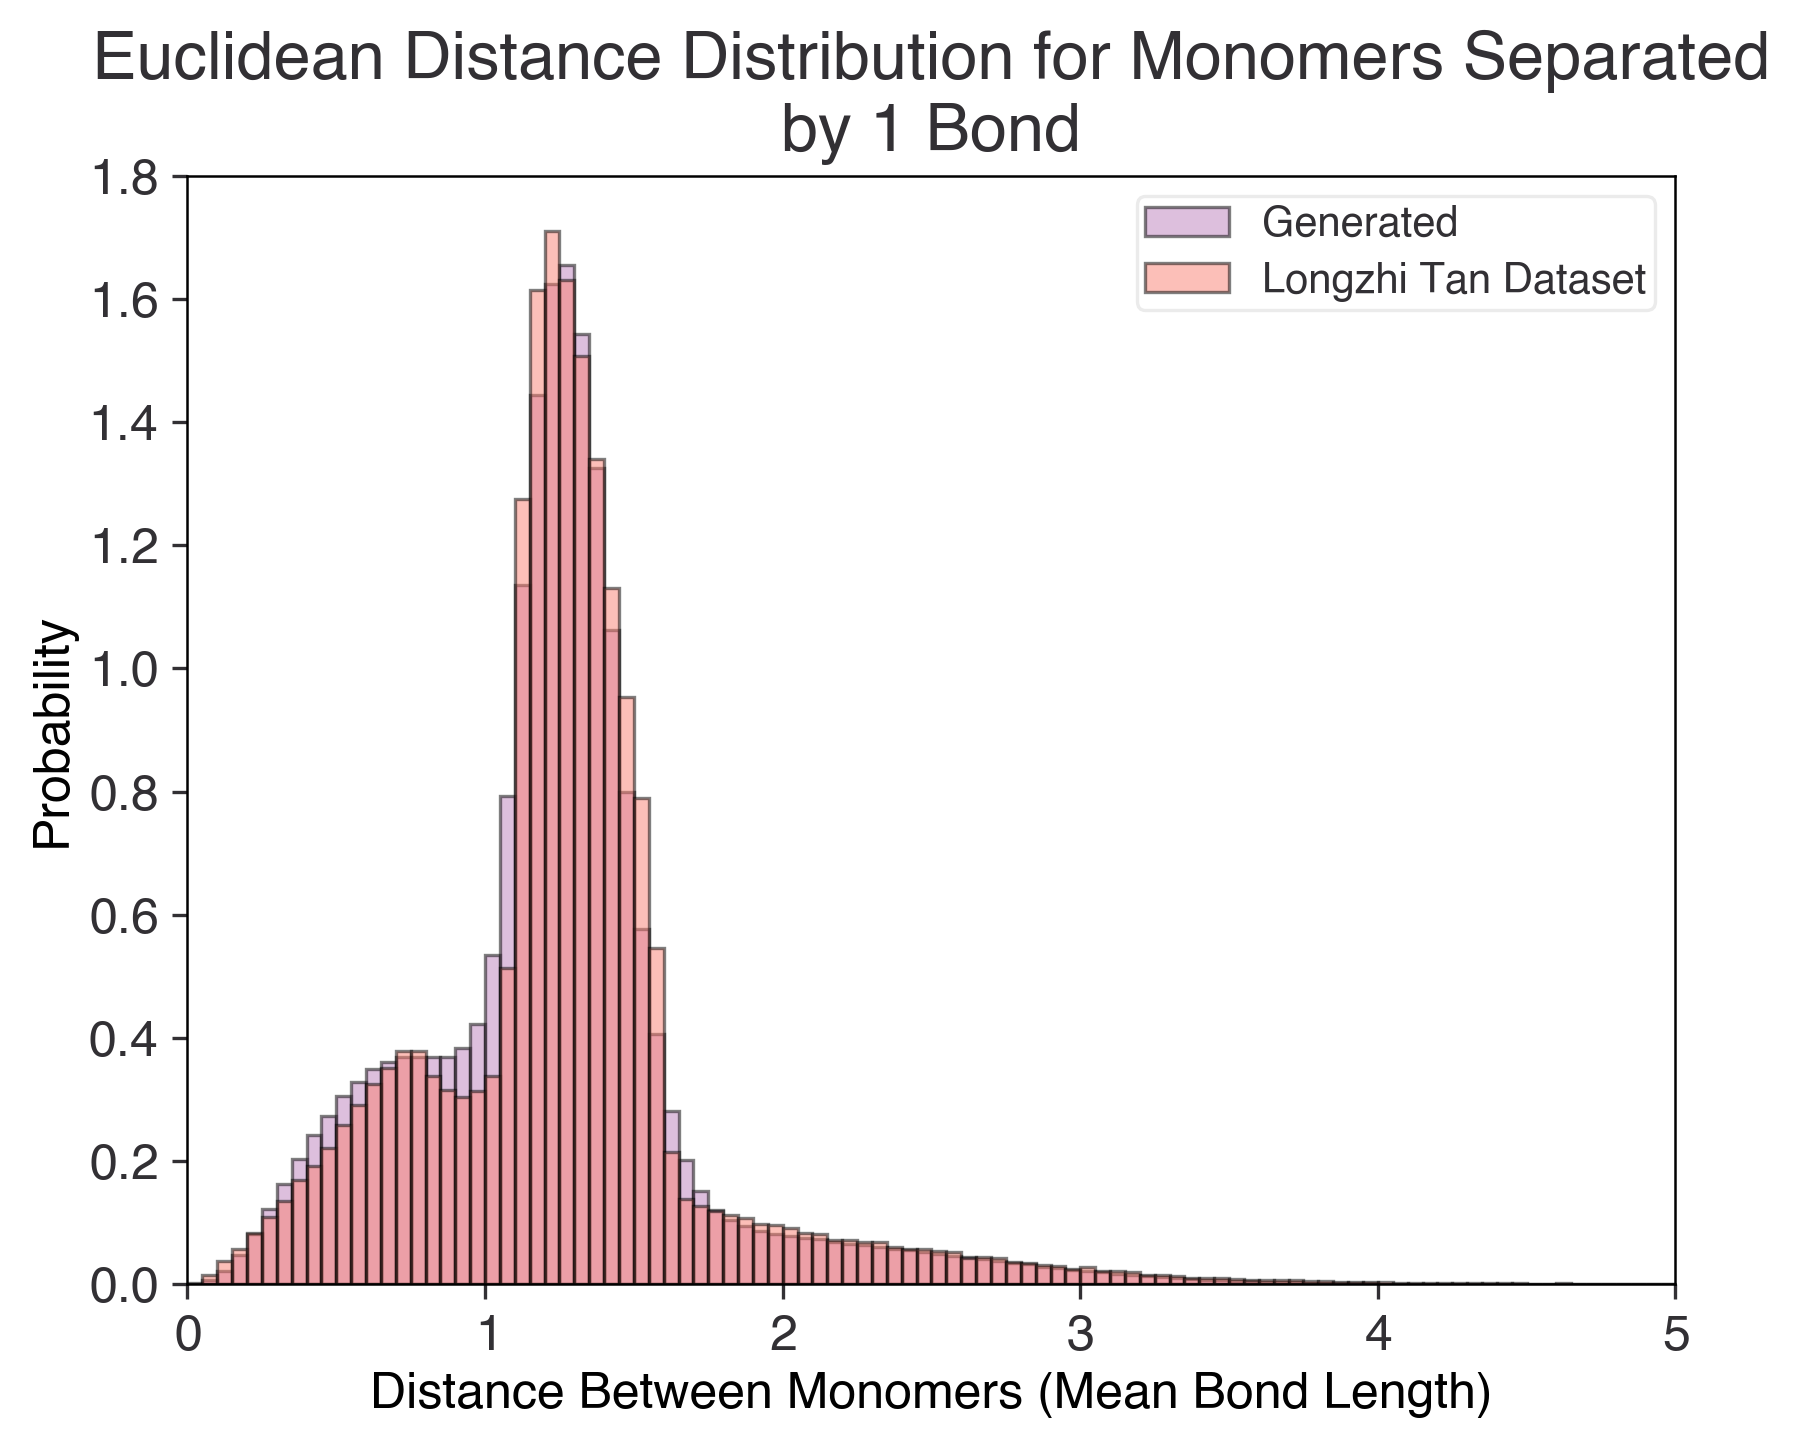

In [20]:
_,fig,ax = dist_compare.compare_specific_separation(1,bins=torch.arange(0,5.04,.05));#,bins=torch.arange(0,10,.05).numpy());
ax.set_xlabel('Distance Between Monomers (Mean Bond Length)')
ax.set_ylabel('Probability')
ax.set_title('Euclidean Distance Distribution for Monomers Separated\nby 1 Bond')
ax.set_xlim([0,5])

fig.savefig(save_folder+f'dists_1{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'E', 'G', 'L', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'w', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 23, 24, 25, 27, 37, 39, 40, 42, 47, 48, 51, 54, 55, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 92, 93]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 46 g

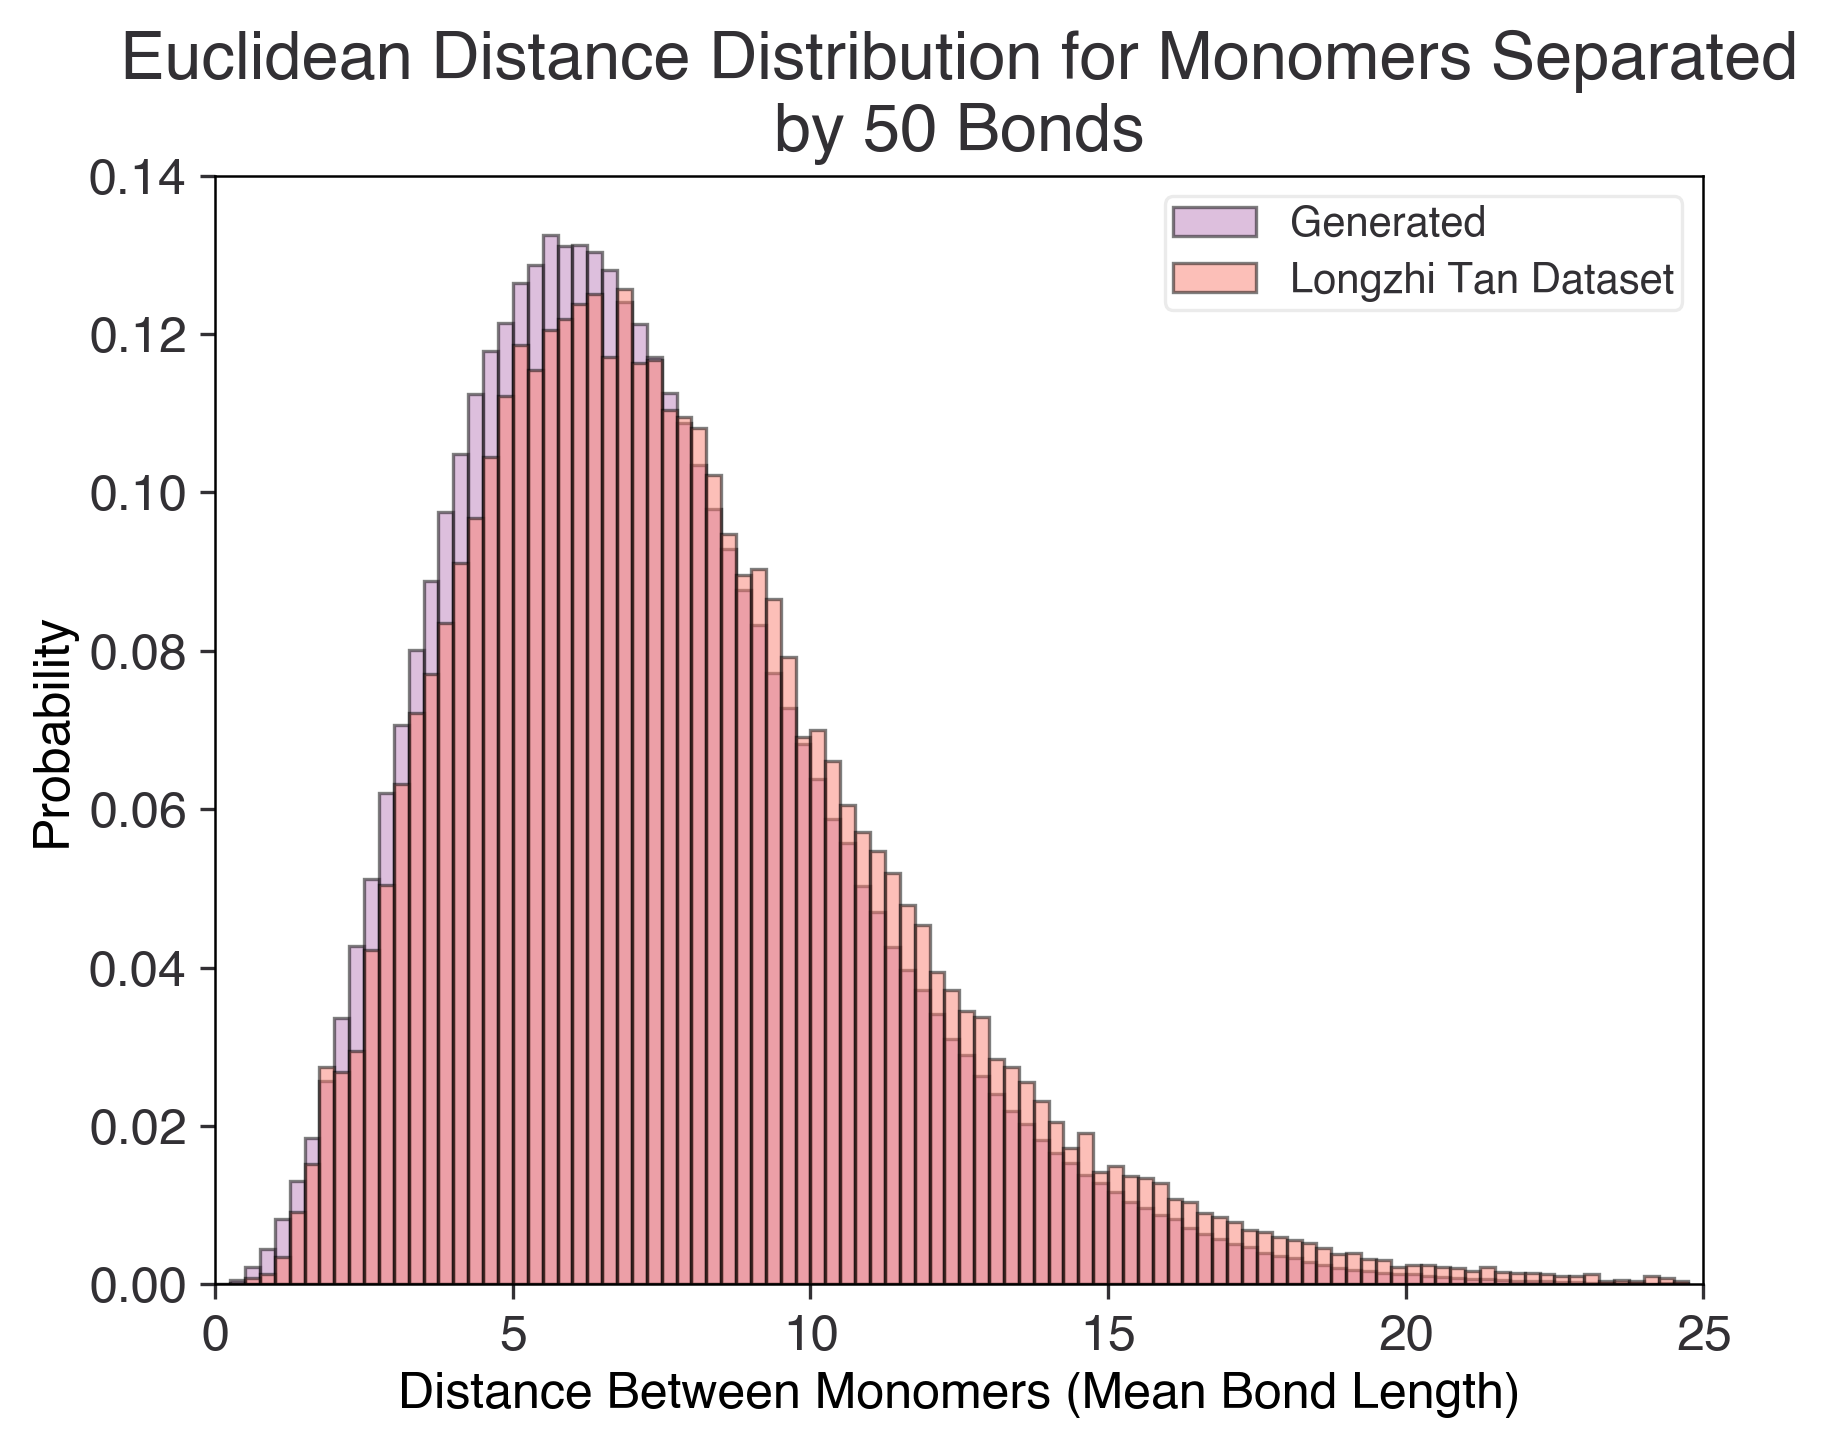

In [21]:
_,fig,ax = dist_compare.compare_specific_separation(50,bins=torch.arange(0,25,.25));#,bins=torch.arange(0,10,.05).numpy());
ax.set_xlabel('Distance Between Monomers (Mean Bond Length)')
ax.set_ylabel('Probability')
ax.set_title('Euclidean Distance Distribution for Monomers Separated\nby 50 Bonds')
ax.set_xlim([0,25])

fig.savefig(save_folder+f'dists_50{file_mod}.pdf')

#### Correlations

In [22]:
def plot_correlations(center_contact=(25,39)):
    
    correlations = dist_compare.correlation_compare(center_contact)

    #i = torch.arange(correlations.shape[-1])
    #correlations[i,i].fill_(torch.nan)
    #print(correlations[i,i])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.matshow(correlations.cpu().numpy(),cmap='magma')
    cbar = fig.colorbar(im)

    #correlations[:] = torch.nan
    #correlations[i,i] = 1
    #ax.matshow(correlations,cmap='Purples',vmin=0,vmax=1)
    
    cbar.set_label('Pearson Correlation Coefficient')
    ax.set_xlabel('Genomic Index')
    ax.set_ylabel('Genomic Index')
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.set_title(f'Correlation between the distance separating\nmonomers {center_contact[0]} and {center_contact[1]} and the distances\nseparating all other interaction pairs')
    
    return fig, ax, im, cbar


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 37 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'I', 'P', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 38, 42, 44, 51, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 39 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 

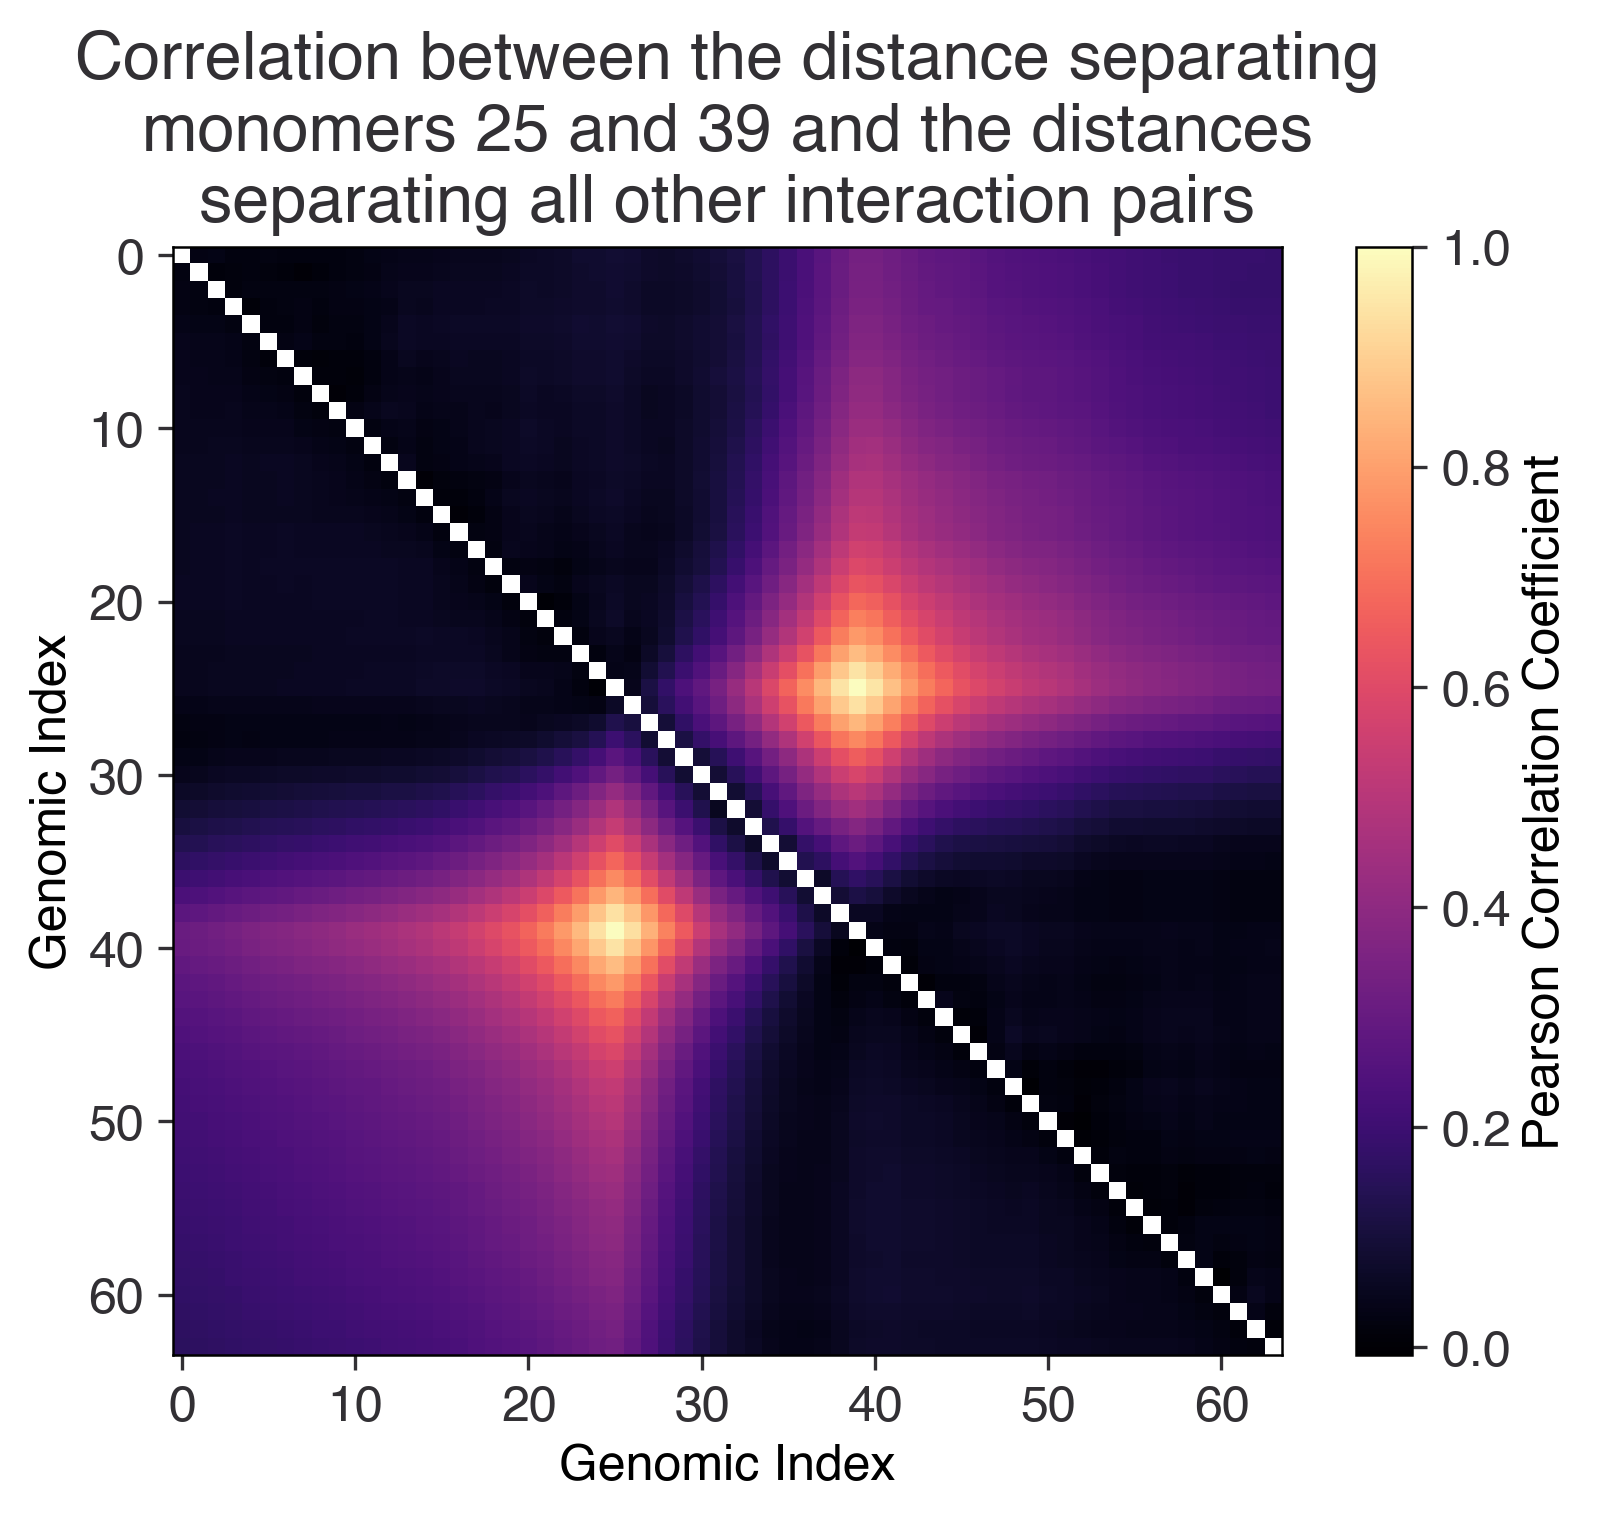

In [23]:
fig,*_=plot_correlations((25,39))

fig.savefig(save_folder+f'correlation_25_39{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'I', 'P', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 27, 38, 42, 44, 51, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'I', 'P

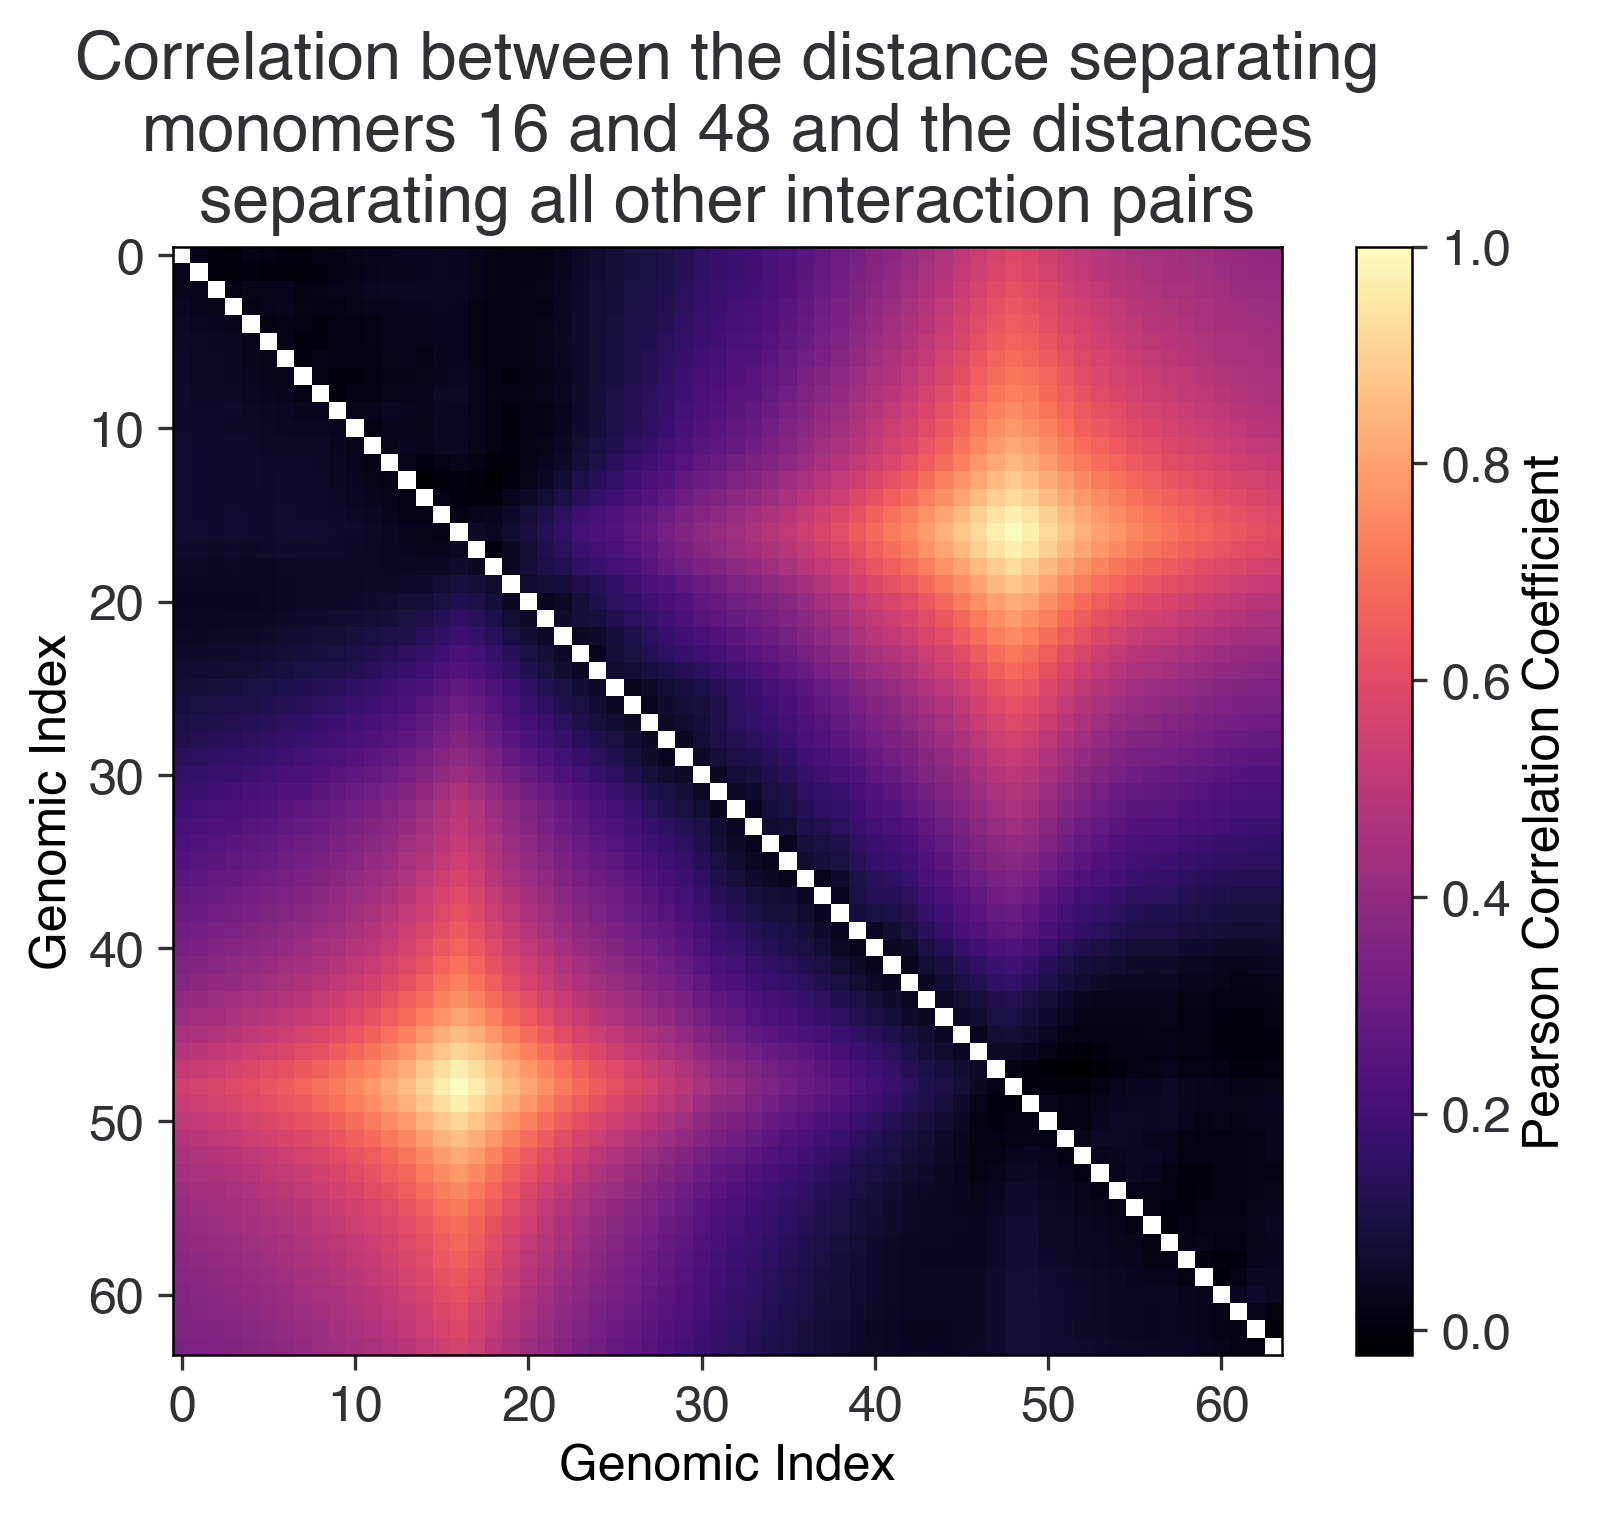

In [24]:
fig,*_=plot_correlations((16,48))

fig.savefig(save_folder+f'correlation_16_48{file_mod}.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 37 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'I', 'P', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 38, 42, 44, 51, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 39 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 

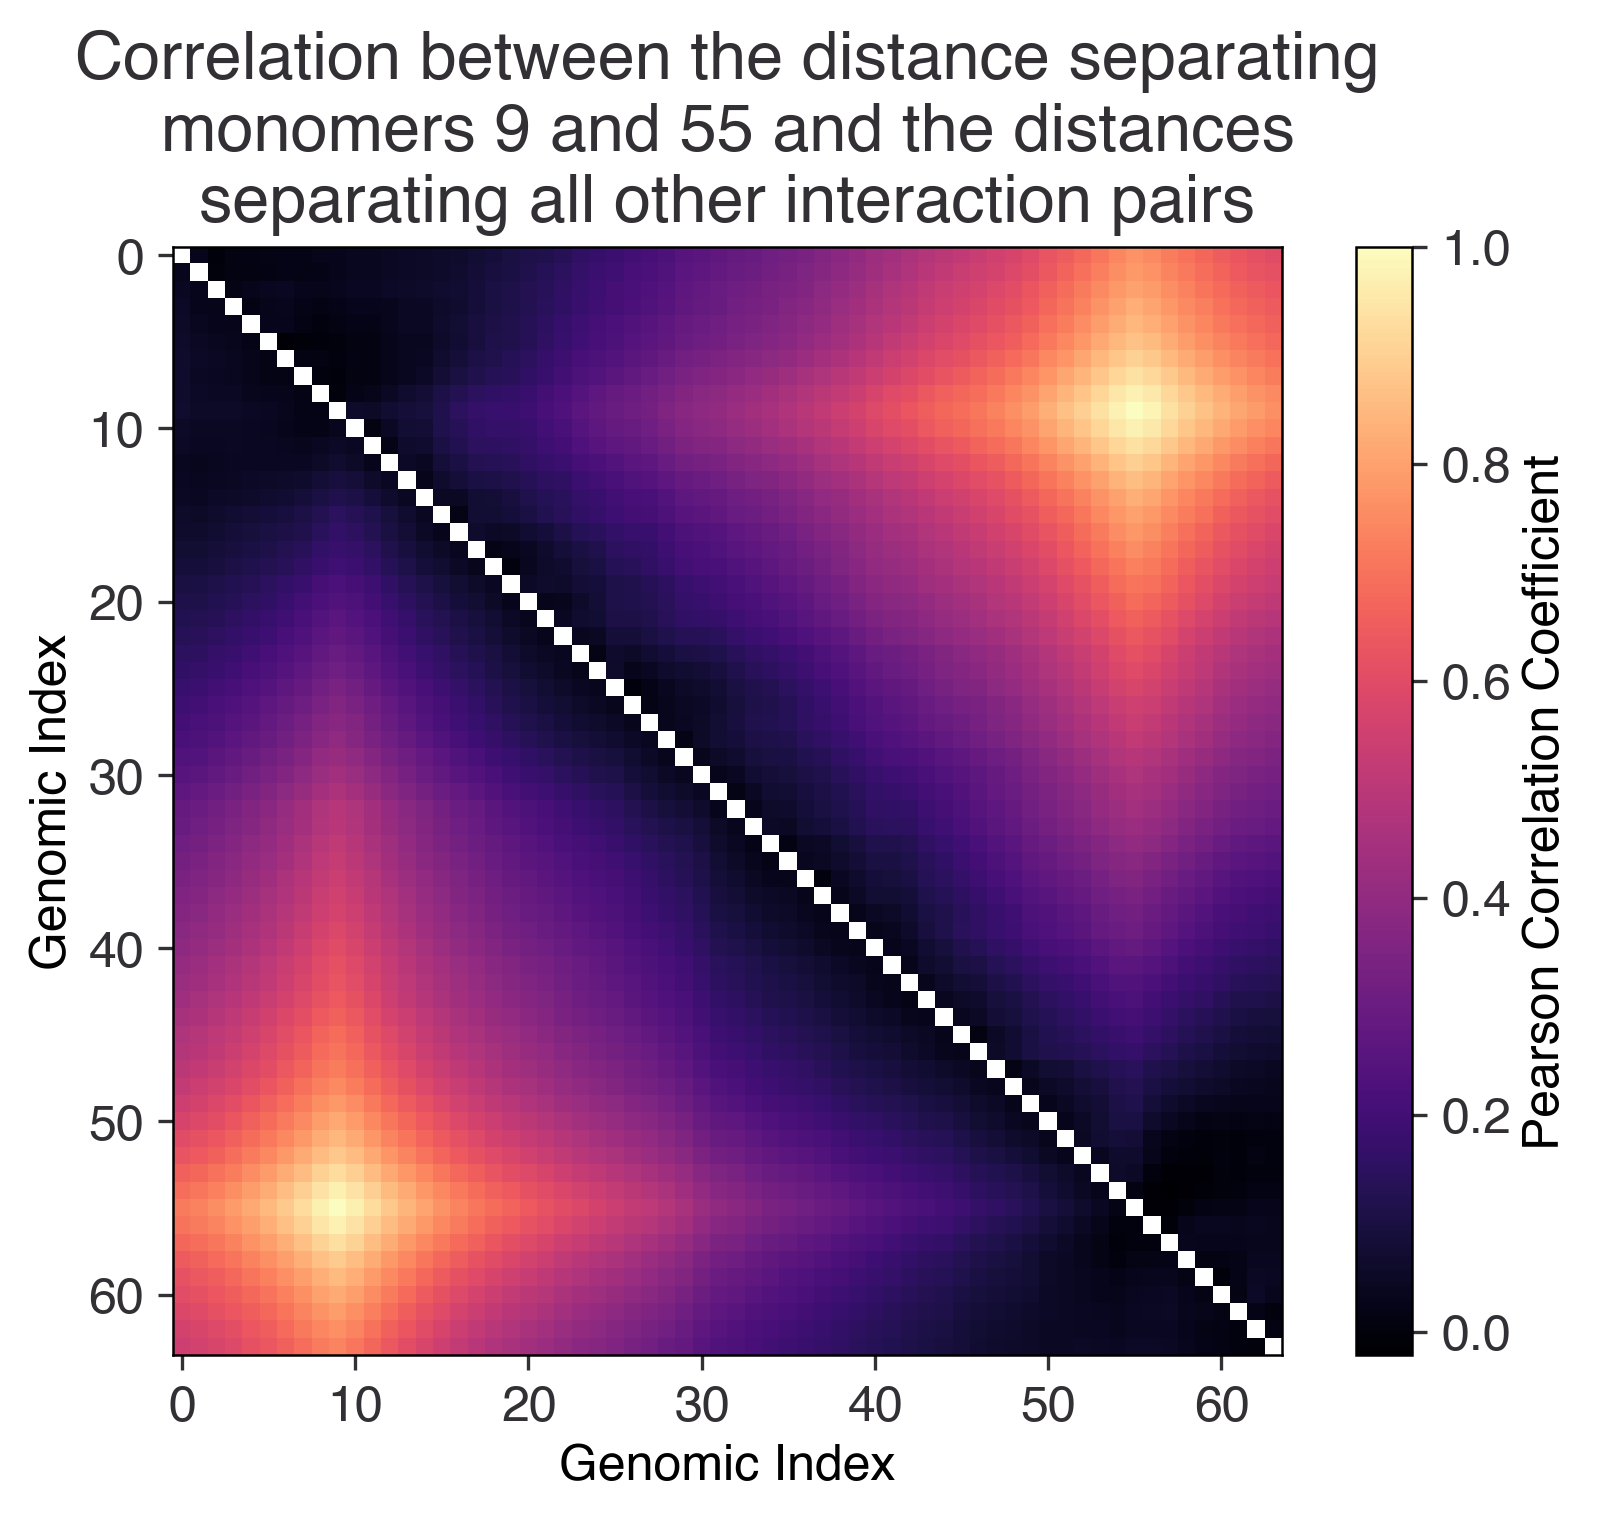

In [25]:
fig,*_=plot_correlations((9,55))

fig.savefig(save_folder+f'correlation_9_55{file_mod}.pdf')

##### RMSD! 

In [26]:
def get_rmsd(coords):
    coords = coords - coords.mean(-2,keepdim=True)
    rmsd = coords.square().sum(-1).mean(-1).sqrt()
    return rmsd

In [27]:
tan_coords = torch.cat(
    [
        config_ds.fetch_coords(si) for si in config_ds.start_indices
    ],
    dim=0
)
if use_corrected_structures:
    gen_coords = coords_from_dcd(gen_dcd,gen_psf)
    
    gen_rmsd = get_rmsd(gen_coords)
    tan_rmsd = get_rmsd(tan_coords)

    fig,ax = distance_hist(tan_rmsd,gen_rmsd,bins=torch.arange(0,15,.5))
    ax.set_title('RMSD Distribution')
    ax.set_xlabel('RMSD')
    ax.set_ylabel('Probability')
else:
    gen_coords = gen_dists
    tan_coords = coords_to_dists(tan_coords)
#fig

NameError: name 'gen_dcd' is not defined

In [ ]:
def population_averaged_distance_matrix(coords,chrom=None,start=None,stop=None):

    assert coords.ndim > 0
    
    while coords.ndim < 3:
        coords = coords.unsqueeze(0)
    coords = coords.flatten(0,-3)
    if coords.shape[-1] == 3:
        mean_dists = coords_to_dists(coords).mean(0)
    else:
        mean_dists = coords.mean(0)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.matshow(-mean_dists.cpu().numpy(),cmap='seismic')
    cbar = fig.colorbar(im)
    cbar.set_ticklabels([
        f'{abs(int(label))}' for label in cbar.get_ticks()
    ])
    cbar.set_label('Distance (mean bond length)')

    title = 'Population-averaged distance matrix'
    if chrom is not None:
        title+=f':\nChromosome {chrom}'
        if start is not None or stop is not None:
            title+= ': '
        if start is not None:
            title+= f'{start}'
        if stop is not None:
            title+= f'-{stop}'
            
    ax.set_title(title)

    return fig,ax,im,cbar
fig,ax,im,cmap=population_averaged_distance_matrix(tan_coords)

In [ ]:
###############
# Select Chromosome for Analysis
chrom = '1'

###############
# Load Tan Configs/related rosetta stone
er_index1 = pd.read_pickle(embedding_dir + '/rosetta_stone.pkl')
config_ds1 = ConfigDataset(
    config_fp,
    segment_length=segment_length,
    remove_diagonal=True,
    batch_size=0,
    normalize_distances=False, #True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[chrom],
    replicates=None,
    shuffle=False,#True,
    allow_overlap=True,#True, # To avoid bias 
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)

In [ ]:
###############
# Choose Region for Analysis
region_idx = 330
milestone = 120
cond_scale = 2.
rescaled_phi = 0.5
dcd_directory = '../../data/samples/origami_64_no_embed_reduction/dcd_files/'

###############
# Load generated conformations
dcd_fp = dcd_directory + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{int(milestone)}_{chrom}.dcd'
psf_fp = dcd_fp.replace('.dcd','.psf')
gen_configs = coords_from_dcd(dcd_fp,psf_fp)

###############
# Fetch Tan conformations
_,chrom_,start_idx = er_index1[chrom][region_idx]
assert chrom == chrom_, 'Chroms don\'t match!'
tan_configs = config_ds1.fetch_specific_coords(chrom,start_idx)[1]

Plot mean distance maps

In [ ]:
fig,ax,im,cmap=population_averaged_distance_matrix(tan_configs)

In [ ]:
fig,ax,im,cmap=population_averaged_distance_matrix(gen_configs)

In [ ]:
fig,ax,im,cmap=population_averaged_distance_matrix(gen_configs[:32,...])

In [ ]:
import mdtraj as md
fs = []
for f in [dcd_fp,psf_fp]:
    f1 = f.split('/')
    f1.insert(-1,'aligned')
    f1 = '/'.join(f1)
    fs.append(f1)

aligned_configs = md.load(fs[0],top=fs[1])
aligned_configs = torch.from_numpy(10*aligned_configs.xyz)
fig,ax,im,cmap=population_averaged_distance_matrix(aligned_configs)
fig,ax,im,cmap=population_averaged_distance_matrix(aligned_configs[:32,...])

In [ ]:
import matplotlib.patheffects as pe
def compare_two_dists(reference,comparison,title=None):

    if reference.shape[-1] == 3:
        dmap = coords_to_dists(reference).mean(0)
    else:
        dmap = reference.mean(0)
        
    n = dmap.shape[-1]
    i,j = torch.triu_indices(n,n,1)
    if comparison.shape[-1] == 3:
        dmap[...,j,i] = coords_to_dists(comparison).mean(0)[...,i,j].to(device=dmap.device,dtype=dmap.dtype)
    else:
        dmap[...,j,i] = comparison.mean(0)[...,i,j].to(device=dmap.device,dtype=dmap.dtype)

    fig,ax,im,cbar = population_averaged_distance_matrix(dmap)

    if title is not None:
        ax.set_title(title)

    ax.text(.995*n-1,.005*n,'Tan Data',horizontalalignment='right',verticalalignment='top',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    ax.text(.005*n,.995*n-1,'Generated Data',horizontalalignment='left',verticalalignment='baseline',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    return fig,ax,im,cbar

In [ ]:
coords_to_dists(tan_configs).mean(0).max()

In [ ]:
fig,ax,im,cbar = compare_two_dists(tan_configs,aligned_configs)
ax.set_title(ax.get_title() + ':\nBest alignment determined by RMSD')

In [ ]:
def by_distance_pcc(generated_conformations,tan_conformations):

    n = tan_conformations.shape[-2]
    i,j = torch.triu_indices(n,n,1)
    td = coords_to_dists(tan_conformations)[...,i,j]
    gd = coords_to_dists(generated_conformations)[...,i,j].to(device=td.device,dtype=td.dtype)

    N = td.shape[0]
    best_frames = torch.empty(N,dtype=int,device=generated_conformations.device)
    for i in range(td.shape[0]):
        temp = torch.cat(
            [
                td[i:i+1,:],
                gd
            ],
            dim=0
        )
        best_frames[i] = torch.corrcoef(temp)[0,1:].max(0)[1]
    return best_frames   

best_frames = by_distance_pcc(tan_configs,aligned_configs)

fig,ax,im,cbar = compare_two_dists(tan_configs,aligned_configs[best_frames,...])
ax.set_title(ax.get_title() + ':\nBest alignment determined by Distmap Correlation')

In [ ]:
def by_distance_SSE(generated_conformations,tan_conformations):

    n = tan_conformations.shape[-2]
    i,j = torch.triu_indices(n,n,1)
    if tan_conformations.shape[-1] == 3:
        td = coords_to_dists(tan_conformations)[...,i,j]
    else:
        td = tan_conformations[...,i,j]
    if generated_conformations.shape[-1] == 3:
        gd = coords_to_dists(generated_conformations)[...,i,j].to(device=td.device,dtype=td.dtype)
    else:
        gd = generated_conformations[...,i,j].to(device=td.device,dtype=td.dtype)

    N = td.shape[0]
    best_frames = torch.empty(N,dtype=int,device=generated_conformations.device)
    for i in range(td.shape[0]):
        temp = td[i:i+1,:].expand_as(gd)
        best_frames[i] = (temp - gd).square().sum(-1).min(0)[1]
    return best_frames   

best_frames = by_distance_SSE(tan_configs,aligned_configs)

#fig,ax,im,cbar = compare_two_dists(gen_coords[best_frames,...],aligned_configs)
fig,ax,im,cbar = compare_two_dists(tan_configs,aligned_configs[best_frames,...])
ax.set_title(ax.get_title() + ':\nBest alignment determined by Distmap SSE\n(Guided Conformations)')

In [ ]:
best_frames = by_distance_SSE(tan_configs,gen_coords.squeeze())#aligned_configs)

#fig,ax,im,cbar = compare_two_dists(gen_coords[best_frames,...],aligned_configs)
fig,ax,im,cbar = compare_two_dists(tan_configs,gen_coords[best_frames,...].squeeze())
ax.set_title(ax.get_title() + ':\nBest alignment determined by Distmap SSE\n(Unguided Conformations)')

#### Individual Conformations

Load data

In [ ]:
###############
# Choose Region for Analysis
#'''
# Frames used for this: 45 & 52
chrom='1'
region_idx = 525
milestone = 120
cond_scale = 3.
rescaled_phi = 0.2
dcd_directory = '../../data/samples/origami_64_no_embed_reduction/temp_for_presentation/aligned/'
'''
# Frames potentially used for this: 4, 23, 63, 
chrom='X'
region_idx = 445
milestone = 120
cond_scale = 4.
rescaled_phi = .5
dcd_directory = '../../data/samples/origami_64_no_embed_reduction/temp_for_presentation/aligned_approach1/'
'''
###############
# Load generated conformations
dcd_fp = dcd_directory + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{int(milestone)}_{chrom}.dcd'
psf_fp = dcd_fp.replace('.dcd','.psf')
aligned_configs = coords_from_dcd(dcd_fp,psf_fp)

###############
# Fetch Tan conformations
_,chrom_,start_idx = er_index1[chrom][region_idx]
assert chrom == chrom_, 'Chroms don\'t match!'

config_ds1 = ConfigDataset(
    config_fp,
    segment_length=segment_length,
    remove_diagonal=True,
    batch_size=0,
    normalize_distances=False, #True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[chrom],
    replicates=None,
    shuffle=False,#True,
    allow_overlap=True,#True, # To avoid bias 
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)

tan_configs = config_ds1.fetch_specific_coords(chrom,start_idx)[1]

In [ ]:
import matplotlib.patheffects as pe

def population_averaged_distance_matrix(coords,chrom=None,start=None,stop=None,cmap='seismic',vmin=None):

    assert coords.ndim > 0
    
    while coords.ndim < 3:
        coords = coords.unsqueeze(0)
    coords = coords.flatten(0,-3)
    if coords.shape[-1] == 3:
        mean_dists = coords_to_dists(coords).mean(0)
    else:
        mean_dists = coords.mean(0)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    #cmap = plt.get_cmap(cmap).copy()

    if vmin is not None and mean_dists.max() <= -vmin:
        vmin = None
    
    im = ax.matshow(-mean_dists.cpu().numpy(),cmap=cmap,vmin=vmin)
    if vmin is not None:
            cbar = fig.colorbar(im,extend='min')
    else:
        cbar = fig.colorbar(im)
    cbar.set_ticklabels([
        f'{abs(int(label))}' for label in cbar.get_ticks()
    ])
    cbar.set_label('Distance (mean bond length)')

    title = 'Population-averaged distance matrix'
    if chrom is not None:
        title+=f':\nChromosome {chrom}'
        if start is not None or stop is not None:
            title+= ': '
        if start is not None:
            title+= f'{start}'
        if stop is not None:
            title+= f'-{stop}'
            
    ax.set_title(title)

    return fig,ax,im,cbar

def compare_two_dists(reference,comparison,title=None,cmap='seismic',vmin=None):

    if reference.shape[-1] == 3:
        dmap = coords_to_dists(reference).mean(0)
    else:
        dmap = reference.mean(0)
        
    n = dmap.shape[-1]
    i,j = torch.triu_indices(n,n,1)
    if comparison.shape[-1] == 3:
        dmap[...,j,i] = coords_to_dists(comparison).mean(0)[...,i,j].to(device=dmap.device,dtype=dmap.dtype)
    else:
        dmap[...,j,i] = comparison.mean(0)[...,i,j].to(device=dmap.device,dtype=dmap.dtype)

    fig,ax,im,cbar = population_averaged_distance_matrix(dmap,cmap=cmap,vmin=vmin)

    if title is not None:
        ax.set_title(title)

    '''
    ax.text(.995*n-1,.005*n,'Tan Data',horizontalalignment='right',verticalalignment='top',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    ax.text(.005*n,.995*n-1,'Generated Data',horizontalalignment='left',verticalalignment='baseline',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    '''
    fontsize='x-large'
    ax.text(.995*n-1,.005*n,'Tan Data',horizontalalignment='right',verticalalignment='top',
            color='black',path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],fontsize=fontsize)

    ax.text(.005*n,.995*n-1,'Generated Data',horizontalalignment='left',verticalalignment='baseline',
            color='black',path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],fontsize=fontsize)
    
    return fig,ax,im,cbar

In [ ]:
sse = (coords_to_dists(tan_configs).squeeze() - coords_to_dists(aligned_configs).squeeze()).square().sum((-2,-1)).squeeze()
mask = torch.ones(len(sse),dtype=bool)

In [ ]:
i = torch.where(sse==sse[mask].min())[0]
fig,ax,im,cbar = compare_two_dists(tan_configs[i:i+1,...],aligned_configs[i:i+1,...])
print(i)

In [ ]:
frame=45
fig,ax,im,cbar = compare_two_dists(tan_configs[frame:frame+1,...],aligned_configs[frame:frame+1,...],vmin=-13)
ax.set_title('Pairwise Distance Map')
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
mask[i] = False
i = torch.where(sse==sse[mask].min())[0]
fig,ax,im,cbar = compare_two_dists(tan_configs[i:i+1,...],aligned_configs[i:i+1,...])#,vmin=-13)
print(i)

In [ ]:
'asdf.pt'[-3:]

In [ ]:
a = torch.rand(5,5,5)
a[a < .5] = torch.nan
#a = torch.nansum(a,dim=(-4,-3,-2,-1))
#while a.ndim > 1:
#    a = torch.nansum(a,dim=-1)
#a.shape

In [ ]:
a.flatten(0,-3).shape

In [ ]:
a = torch.rand(10,5,5)
b = torch.randint(size=(10,),low=0,high=2).bool()
a[b].shape

In [ ]:
a = torch.zeros(10,5,5)
b = torch.randint(size=(10,),low=0,high=2).bool()
c = a[b]

In [ ]:
c.shape

In [ ]:
c[:] = 1

In [ ]:
a